# 0.0 Imports

In [38]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import sweetviz          as sv
import xgboost           as xgb
import tensorflow        as tf
import inflection
import pickle
import requests
import warnings
warnings.filterwarnings('ignore')

from matplotlib              import pyplot    as plt
from scipy                   import stats     as ss
from sklearn                 import ensemble  as en
from sklearn                 import neighbors as nh
from boruta                  import BorutaPy
from imblearn.combine        import SMOTETomek
from imblearn.over_sampling  import SMOTE
from tabulate                import tabulate
from sklearn.preprocessing   import StandardScaler, RobustScaler
from IPython.core.display    import HTML
from skopt                   import gp_minimize
from sklearn.metrics         import roc_auc_score, precision_score, recall_score, confusion_matrix
from IPython.display         import Image
from sklearn.preprocessing   import MinMaxScaler, LabelEncoder, RobustScaler
from imblearn.under_sampling import ClusterCentroids
from sklearn.model_selection import train_test_split
from sklearn.experimental    import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import f1_score
from scikitplot.metrics      import plot_cumulative_gain, plot_lift_curve, plot_ks_statistic, plot_calibration_curve, plot_confusion_matrix 
from sklearn.linear_model    import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.datasets        import make_classification
from yellowbrick.classifier  import ClassPredictionError, ROCAUC, PrecisionRecallCurve, ConfusionMatrix

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1)*(r - 1) / (n - 1))
    
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (k - 1)**2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

def ml_acc( model_name, y, yhat ):
    acc = accuracy_score( y, yhat )
    f1 = f1_score( y, yhat )
    recall = recall_score(y, yhat) 
    precision = precision_score(y, yhat) 
    
    return pd.DataFrame( { 'Model Name': model_name,
                            'Accuracy': acc,
                            'f1_score': f1,
                            'Recall': recall,
                            'Precision': precision}, index=[0] )

def cross_validation(model_name, model, x_train, y_train, k, verbose=False):
    '''Função para realizar o Cross Validation dos modelos de Machine Learning'''
    precision_k_list = []
    recall_k_list    = []
    
    kfolds = StratifiedKFold(n_splits = 5, shuffle=True, random_state=5)
    
    for cv_train, cv_val in kfolds.split(x_train, y_train):
        
        # Cross-Validation Train
        xtrain_val = x_train.iloc[cv_train]
        ytrain_val = y_train.iloc[cv_train]
        
        # Cross-Validation Validation
        xval = x_train.iloc[cv_val]
        yval = y_train.iloc[cv_val]
        
        # Treinamento do modelo
        model.fit(xtrain_val, ytrain_val)

        # Previsão
        yhat_prob  = model.predict_proba(xval)
        yhat       = model.predict(xval)
        
        # Preparando os Dados
        data = xval.copy()
        data['response'] = yval.copy()

        # Score
        data['score'] = yhat_prob[:, 1].tolist()

        data = data.sort_values('score', ascending = False)

        # Performance
        precision_k = precision_at_k(data, k)
        precision_k_list.append(precision_k)
        
        recall_k = recall_at_k(data, k)
        recall_k_list.append(recall_k)
        
        acc = accuracy_score(yval, yhat)
        
        f1 = f1_score(yval, yhat)
        
    return pd.DataFrame({'Precision @k - CV': np.round(np.mean(precision_k_list), 3),
                         'Recall @k - CV': np.round(np.mean(recall_k_list), 3),
                         'Accuracy - CV': np.round(np.mean(acc), 3),
                         'F1_score - CV': np.round(np.mean(f1), 3)},index=[model_name])

def treinar_modelo_rfc(params):
    max_depth = params[0]
    print(params, '\n')
    

    mdl = RandomForestClassifier(max_depth=max_depth, n_estimators=600, random_state=42)

    mdl.fit(X_train, y_train)

    p = mdl.predict_proba(X_test)[:, 1]

    return -roc_auc_score(y_test, p)

def precision_at_k(data, k=2000):
    '''Função para calcular o precision @ k do modelo'''
    data = data.reset_index(drop=True)
    
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

def recall_at_k(data, k=2000):
    '''Função para calcular a recall @ k do modelo'''
    data = data.reset_index(drop=True)
    
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_raw = pd.read_csv('../data/raw/churn.csv', low_memory=False)

In [5]:
df_raw.sample()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1339,1340,15761132,Capon,682,Spain,Male,46,7,128029.72,1,1,1,62615.35,0


# 1.0 Data Description

In [6]:
# Cópia para otimização
df1 = df_raw.copy()

- RowNumber: Número total de colunas do dataset
- CustomerID: Identificador único do cliente
- Surname: Último nome do cliente
- CreditScore: Score do cartão do cliente 
- Geography: Localidade ( País ) do cliente
- Gender: Gênero do cliente
- Age: Idade do cliente
- Tenure: Quantidade de anos que o cliente contrata serviços com o banco 
- Balance: Saldo atual do cliente em sua conta no banco
- NumOfProducts: Quantidade de produtos que o cliente comprou 
- HasCrCard: Se o cliente possui ( 1 ) cartão de crédito ou não ( 0 ) 
- IsActiveMember: Se o cliente é ativo ( Nos últimos 12 meses ) 
- EstimateSalary: Salário anual estimado do cliente
- Exited: Se o cliente entrou em churn ( 1 ) ou não ( 0 )

## 1.1 Rename Columns

In [7]:
# Rename to snake_case format
old_cols = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

snake_case = lambda x: inflection.underscore(x)

new_cols = list( map(snake_case, old_cols))
df1.columns = new_cols

## 1.2 Data Dimensions

In [8]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 10000
Number of columns: 14


## 1.3 Data Types

In [9]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Check NA 

In [10]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5 Fillout NA 

- Não há dados NA no dataset

## 1.6 Change Types

- Não há dados para mudar no dataset

## 1.7 Descriptive Statistical

In [11]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'])

### 1.7.1 Numerical Attributes

In [12]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, max, min, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,row_number,1.00,10000.00,9999.00,5.000500e+03,5.000500e+03,2886.751332,0.000000,-1.200000
1,customer_id,15565701.00,15815690.00,249989.00,1.569094e+07,1.569074e+07,71932.589224,0.001149,-1.196113
2,credit_score,350.00,850.00,500.00,6.505288e+02,6.520000e+02,96.648466,-0.071607,-0.425726
3,age,18.00,92.00,74.00,3.892180e+01,3.700000e+01,10.487282,1.011320,1.395347
4,tenure,0.00,10.00,10.00,5.012800e+00,5.000000e+00,2.892030,0.010991,-1.165225
5,balance,0.00,250898.09,250898.09,7.648589e+04,9.719854e+04,62394.285254,-0.141109,-1.489412
6,num_of_products,1.00,4.00,3.00,1.530200e+00,1.000000e+00,0.581625,0.745568,0.582981
7,has_cr_card,0.00,1.00,1.00,7.055000e-01,1.000000e+00,0.455818,-0.901812,-1.186973
8,is_active_member,0.00,1.00,1.00,5.151000e-01,1.000000e+00,0.499772,-0.060437,-1.996747
9,estimated_salary,11.58,199992.48,199980.90,1.000902e+05,1.001939e+05,57507.617221,0.002085,-1.181518


<AxesSubplot:xlabel='estimated_salary'>

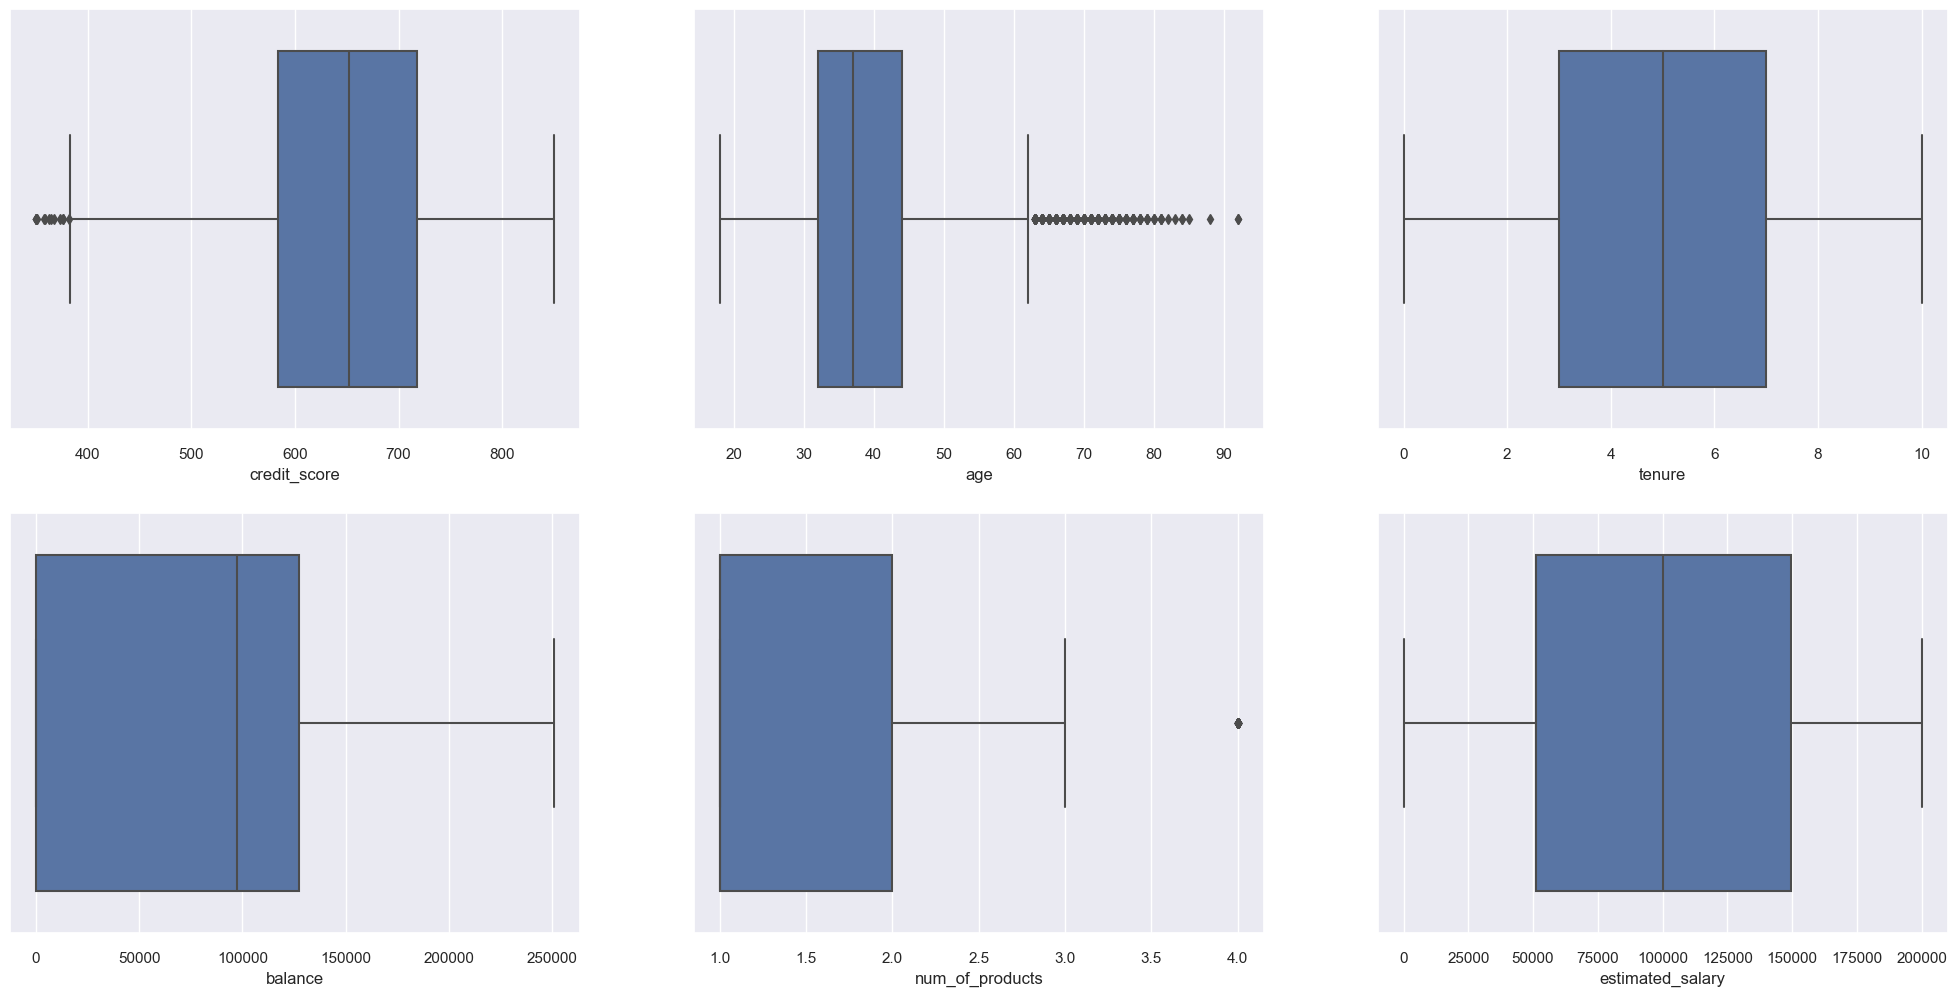

In [13]:
# Análise das variáveis numéricas no boxplot
plt.subplot(2, 3, 1)
sns.boxplot(x='credit_score', data=num_attributes)

plt.subplot(2, 3, 2)
sns.boxplot(x='age', data=num_attributes)

plt.subplot(2, 3, 3)
sns.boxplot(x='tenure', data=num_attributes)

plt.subplot(2, 3, 4)
sns.boxplot(x='balance', data=num_attributes)

plt.subplot(2, 3, 5)
sns.boxplot(x='num_of_products', data=num_attributes)

plt.subplot(2, 3, 6)
sns.boxplot(x='estimated_salary', data=num_attributes)

### 1.7.2 Categorical Attributes

In [ ]:
# Quantas variáveis categóricas em cada feature
cat_attributes.apply( lambda x: x.unique().shape[0] )

In [14]:
# Quais variáveis
cat_attributes.apply( lambda x: x.unique() )

surname      [Hargrave, Hill, Onio, Boni, Mitchell, Chu, Ba...
geography                             [France, Spain, Germany]
gender                                          [Female, Male]
dtype: object

<AxesSubplot:xlabel='gender', ylabel='exited'>

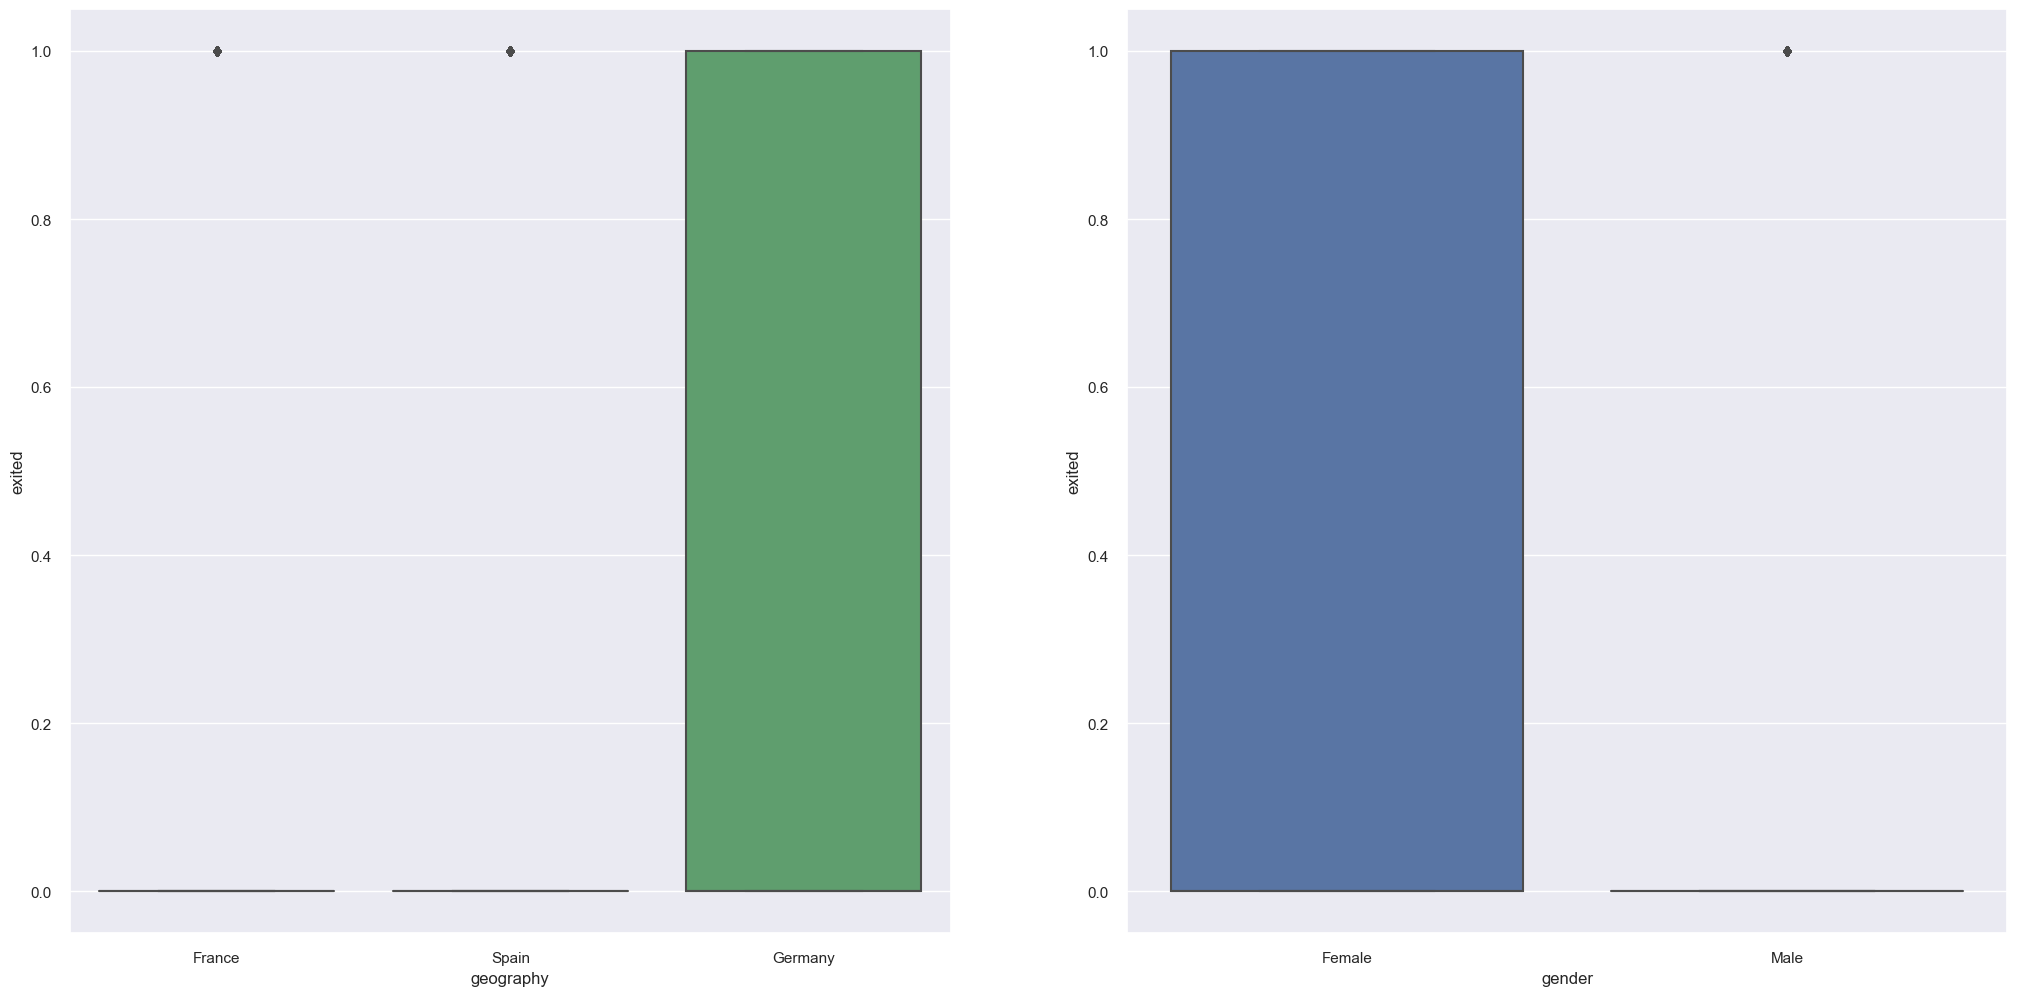

In [15]:
# Ignoring surname column
plt.subplot(1, 2, 1)
sns.boxplot(x='geography', y='exited', data=df1)

plt.subplot(1, 2, 2)
sns.boxplot(x='gender', y='exited', data=df1)

# 2.0 Feature Engineering

In [16]:
df2 = df1.copy()

## 2.1 MindMap Hypothesis

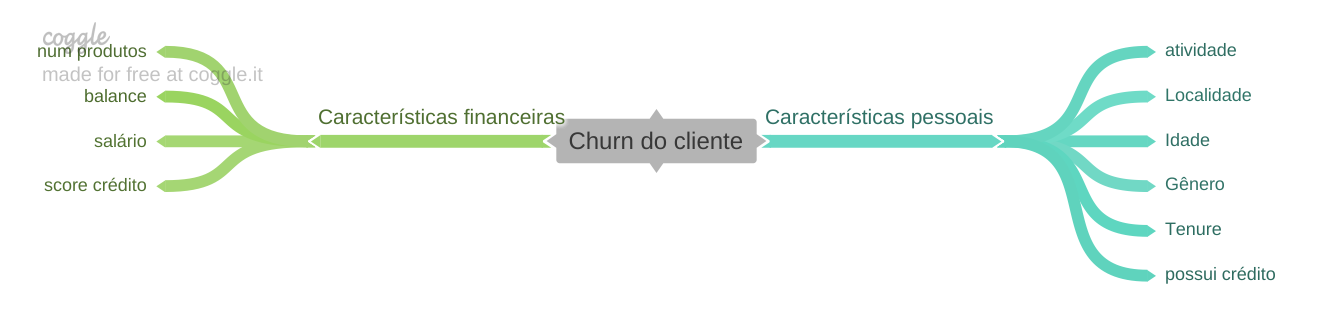

In [17]:
Image('../reports/figures/mind_map_churn.png')

## 2.2 Creating Hypothesis

### 2.2.1 Hipóteses Características Pessoais

- 1.A atividade do cliente influencia em possível churn?
- 2.A localidade do cliente influencia em possível churn?
- 3.A idade do cliente influencia em possível churn?
- 4.O gênero do cliente influencia em possível churn?
- 5.A tenure do cliente influencia em possível churn?
- 6.O fato do cliente possuir cartão de crédito influencia em possível churn?

### 2.2.2 Hipóteses Características Financeiras

- 1.O salário do cliente influencia em possível churn?
- 2.O score do cliente influencia em possível churn?
- 3.O número de produtos comprados pelo cliente influencia em possível churn?
- 4.O balanço financeiro do cliente influencia em possível churn?

## 2.3 Final List of Hypothesis

- 1.O salário do cliente influencia em possível churn?
- 2.O balanço financeiro do cliente influencia em possível churn?
- 3.A idade do cliente influencia em possível churn?
- 4.A tenure do cliente influencia em possível churn?
- 5.O score do cliente influencia em possível churn?
- 6.O número de produtos comprados pelo cliente influencia em possível churn?

## 2.4 Feature Engineering

In [18]:
# High Age Feature - Tendem a realizar o churn mais facilmente
df2['high_age'] = df2['age'].apply(lambda x: 1 if x > 48 else 0)

# Medium Balance Feature - Tendem a realizar o churn mais facilmente
df2['medium_balance'] = df2['balance'].apply(lambda x: 1 if 100000.00 < x < 150000.00 else 0)

# Null Balance Feature - Tendem a não realizar o churn de forma significativa
df2['null_balance'] = df2['balance'].apply(lambda x: 1 if x == 0 else 0)

# Number of Products Feature
df2['low_products'] = df2['num_of_products'].apply(lambda x: 1 if x == 1 or x == 2 else 0)
df2['high_products'] = df2['num_of_products'].apply(lambda x: 1 if x == 3 or x == 4 else 0)

# Estimated Monthly Salary Feature
df2['estimated_monthly_salary'] = df2['estimated_salary'].apply(lambda x: x / 12)

# 3.0 Filtragem de Variáveis

In [19]:
df3 = df2.copy()

In [20]:
df3.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,high_age,medium_balance,null_balance,low_products,high_products,estimated_monthly_salary
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0,0,1,1,0,8445.740000
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,0,1,0,9378.548333
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0,0,0,0,1,9494.297500
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,0,1,1,0,7818.885833
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0,6590.341667


## 3.1 Filtragem de linhas 

- Sem linhas para filtrar

## 3.2 Filtragem de colunas

In [21]:
cols_drop = ['row_number', 'customer_id', 'surname']

df3 = df3.drop(cols_drop, axis=1)

# 4.0 Análise Exploratória de Dados

In [22]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

<AxesSubplot:xlabel='exited', ylabel='Density'>

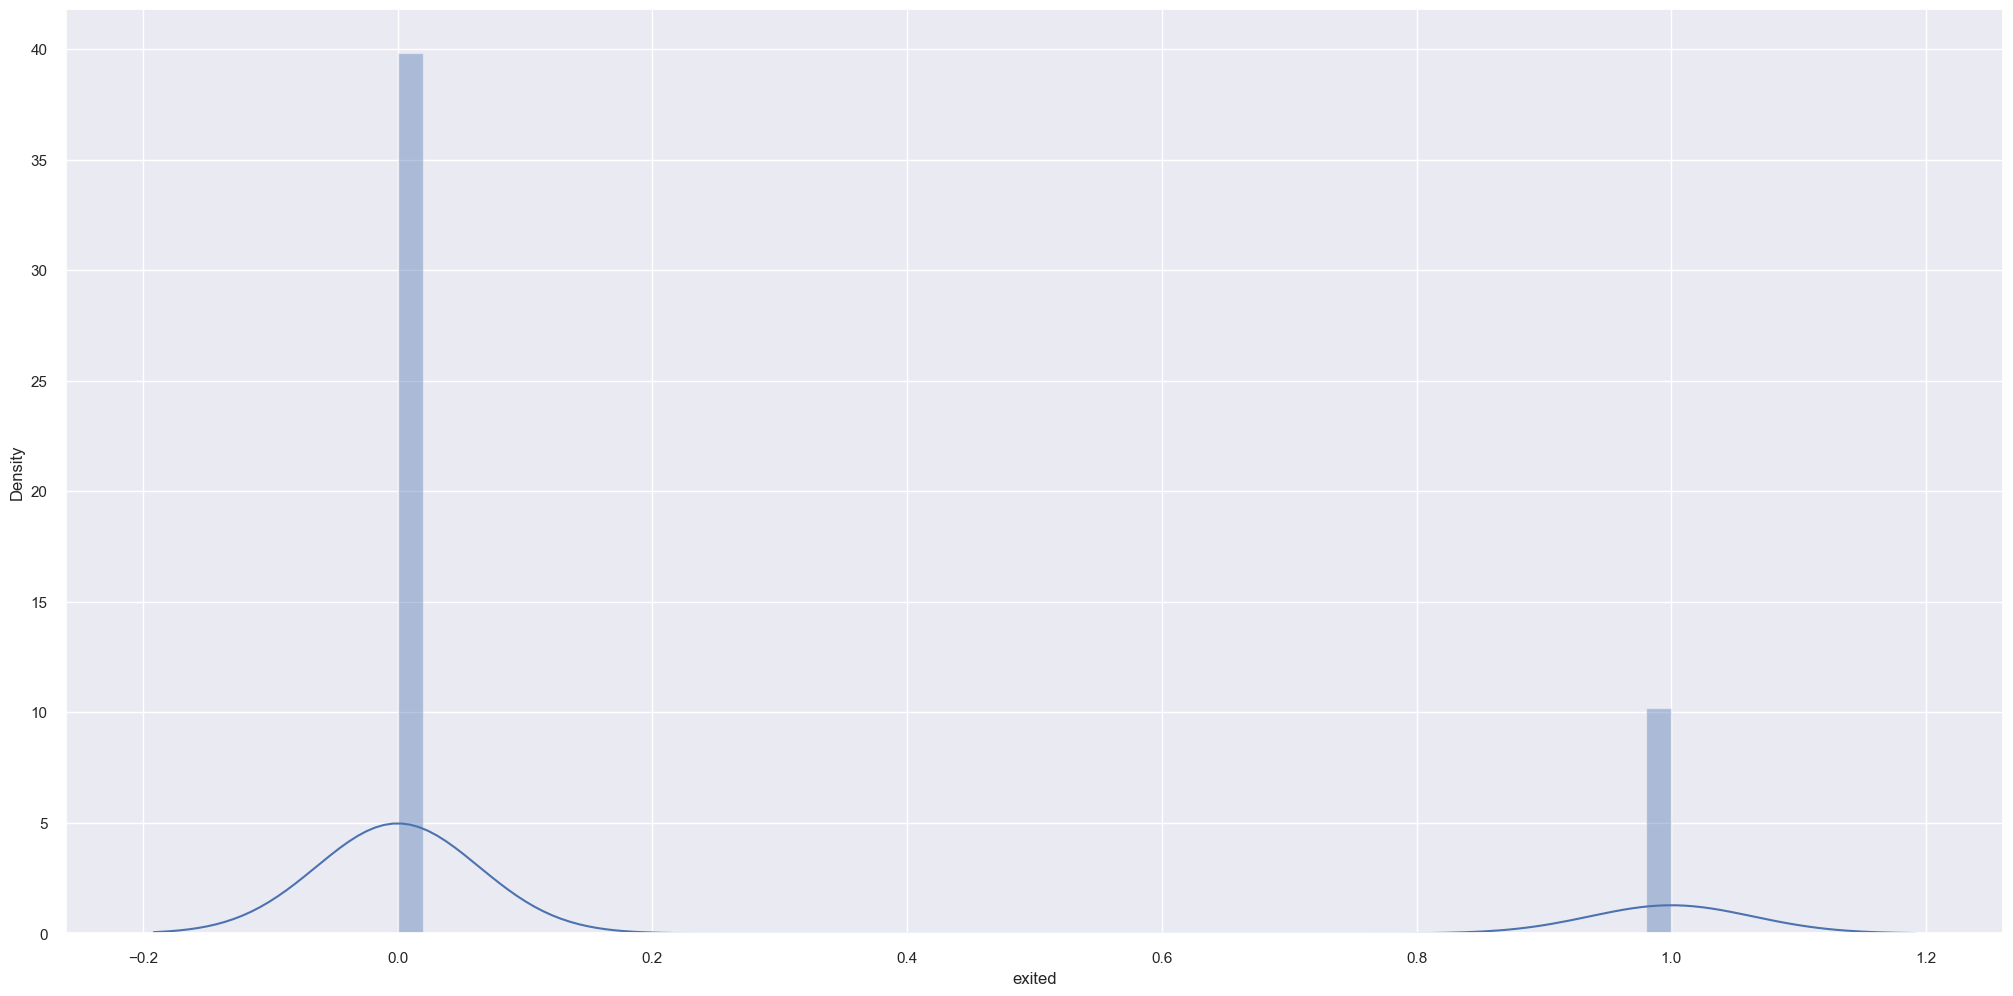

In [23]:
# Exited Variable
sns.distplot(df4['exited'])

In [ ]:
# Taxa de Churn atual da empresa
df4['exited'].value_counts(normalize=True)*100 

### 4.1.2 Numerical Variable

array([[<AxesSubplot:title={'center':'row_number'}>,
        <AxesSubplot:title={'center':'customer_id'}>,
        <AxesSubplot:title={'center':'credit_score'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'tenure'}>,
        <AxesSubplot:title={'center':'balance'}>],
       [<AxesSubplot:title={'center':'num_of_products'}>,
        <AxesSubplot:title={'center':'has_cr_card'}>,
        <AxesSubplot:title={'center':'is_active_member'}>],
       [<AxesSubplot:title={'center':'estimated_salary'}>,
        <AxesSubplot:title={'center':'exited'}>, <AxesSubplot:>]],
      dtype=object)

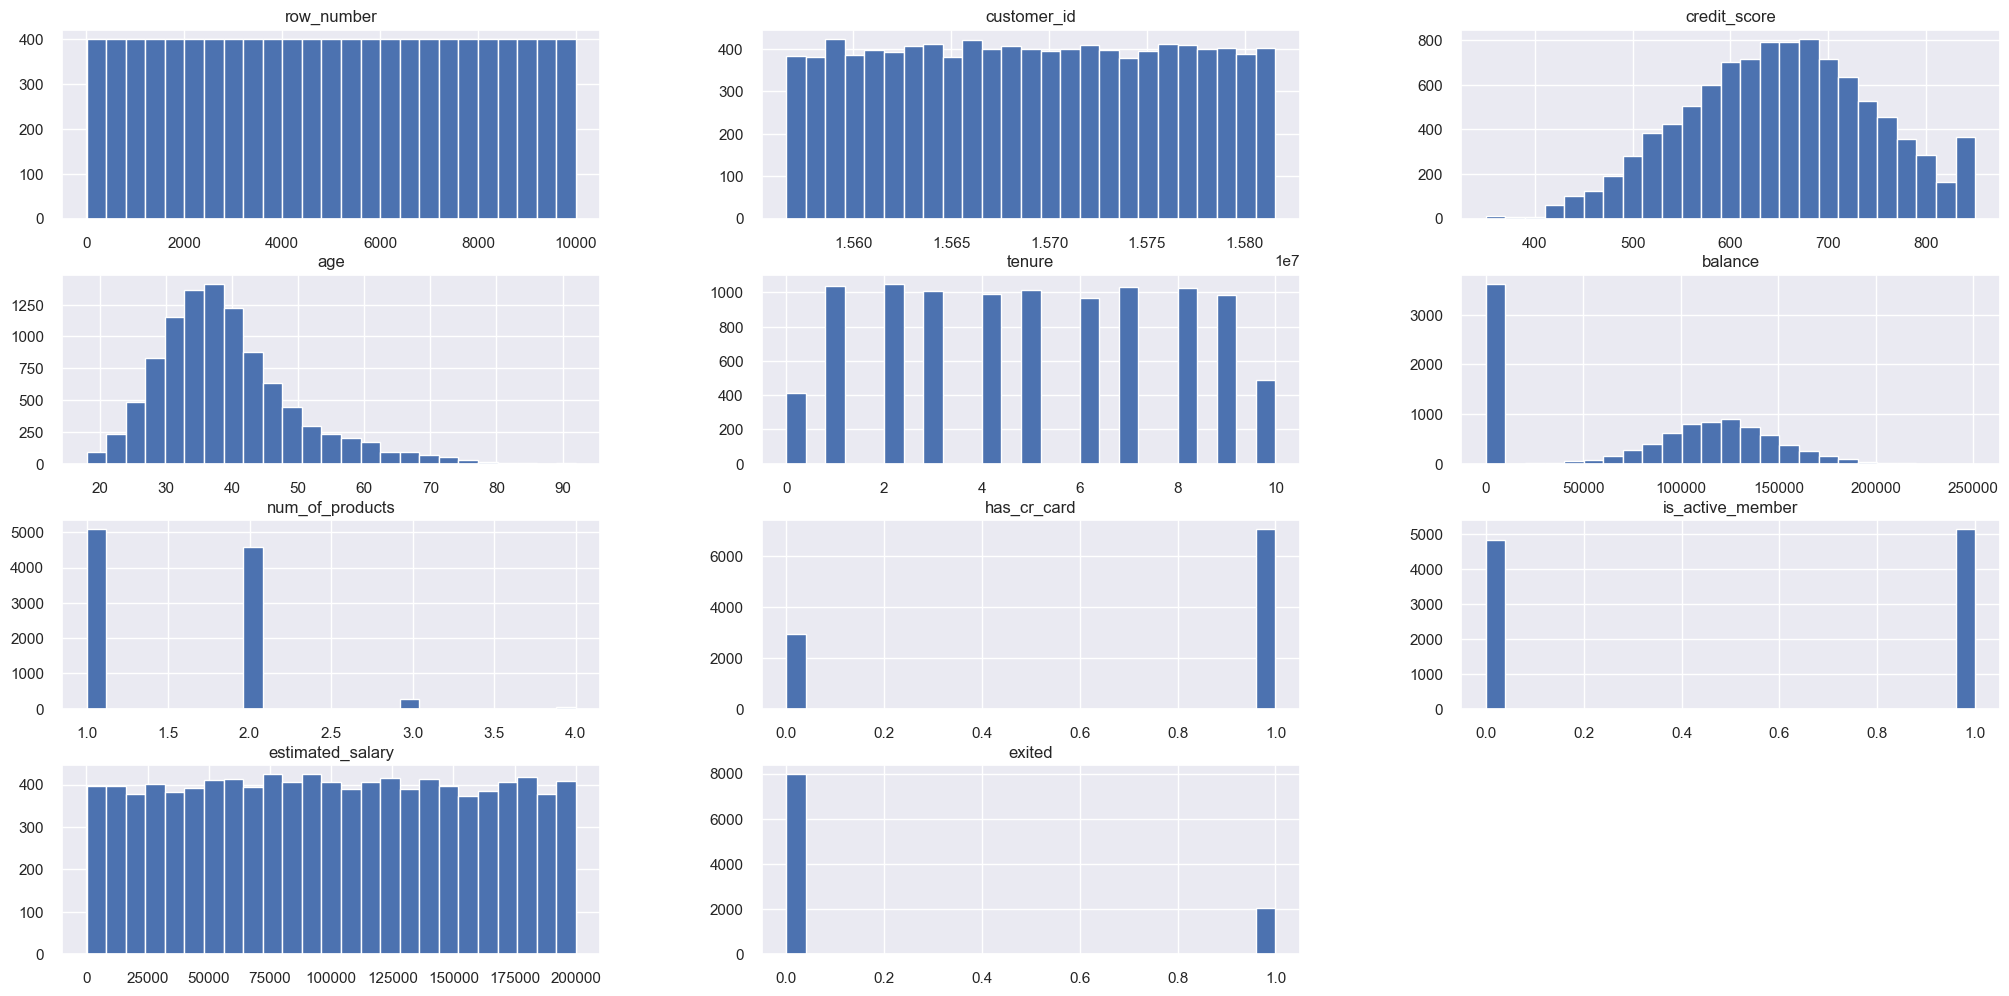

In [24]:
# Atributos numéricos 
num_attributes.hist(bins=25)

### 4.1.3 Categorical Variable

In [ ]:
# geography
plt.subplot( 2, 2, 1 )
sns.countplot( df4['geography'] )

plt.subplot( 2, 2, 2 )
sns.kdeplot( df4[df4['geography'] == 'France']['exited'], label='France', shade=True )
sns.kdeplot( df4[df4['geography'] == 'Spain']['exited'], label='Spain', shade=True )
sns.kdeplot( df4[df4['geography'] == 'Germany']['exited'], label='Germany', shade=True )

# gender
plt.subplot( 2, 2, 3 )
sns.countplot( df4['gender'] )

plt.subplot( 2, 2, 4 )
sns.kdeplot( df4[df4['gender'] == 'Female']['exited'], label='Female', shade=True )
sns.kdeplot( df4[df4['gender'] == 'Male']['exited'], label='Male', shade=True )

## 4.2 Análise Bivariada

### H1. O salário do cliente influencia em possível churn?

### VERDADEIRA. O salário influencia de forma leve, porém significativa em um trecho do gráfico. Clientes com os melhores salários estimados anuais tendem a realizar o churn mais facilmente (A partir dos 170k anuais)

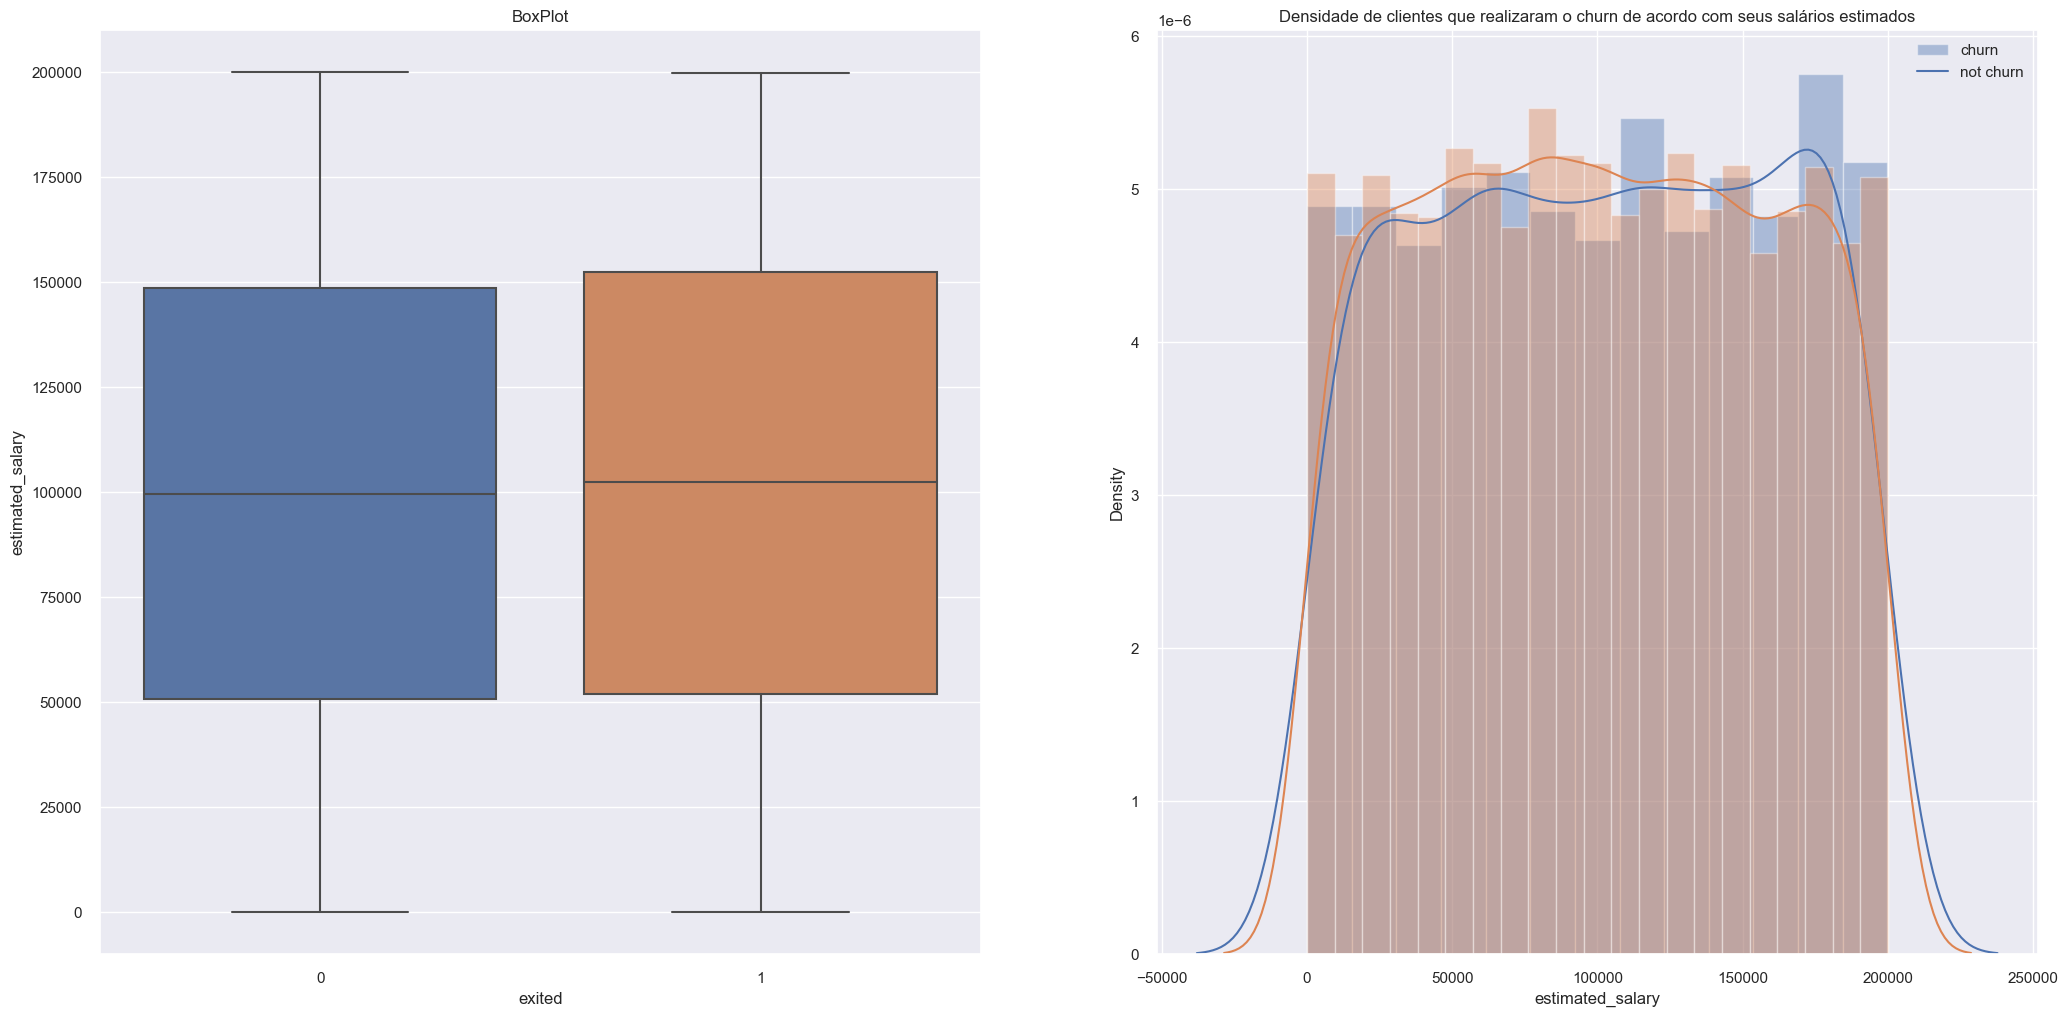

In [25]:
plt.subplot( 1, 2, 1 )
sns.boxplot(x='exited', y='estimated_salary', data=df4).set_title('BoxPlot') ; 

plt.subplot( 1, 2, 2 )
sns.distplot(df4[df4['exited'] == 1]['estimated_salary'], label='churn') 
sns.distplot(df4[df4['exited'] == 0]['estimated_salary'], label='not churn') 
plt.title('Densidade de clientes que realizaram o churn de acordo com seus salários estimados')
plt.legend(['churn', 'not churn']) ;

### H2. A quantidade de dinheiro localizada na conta do cliente (Balance) influencia em possível churn?

### VERDADEIRA. A feature Balance influencia de maneira positiva quanto ao churn de cliente, uma vez que percebe-se que na faixa entre 100k e 150k, há a maior tendência de churn, emquanto na faixa nula (0k) há maior tendência de não ocorrer o churn

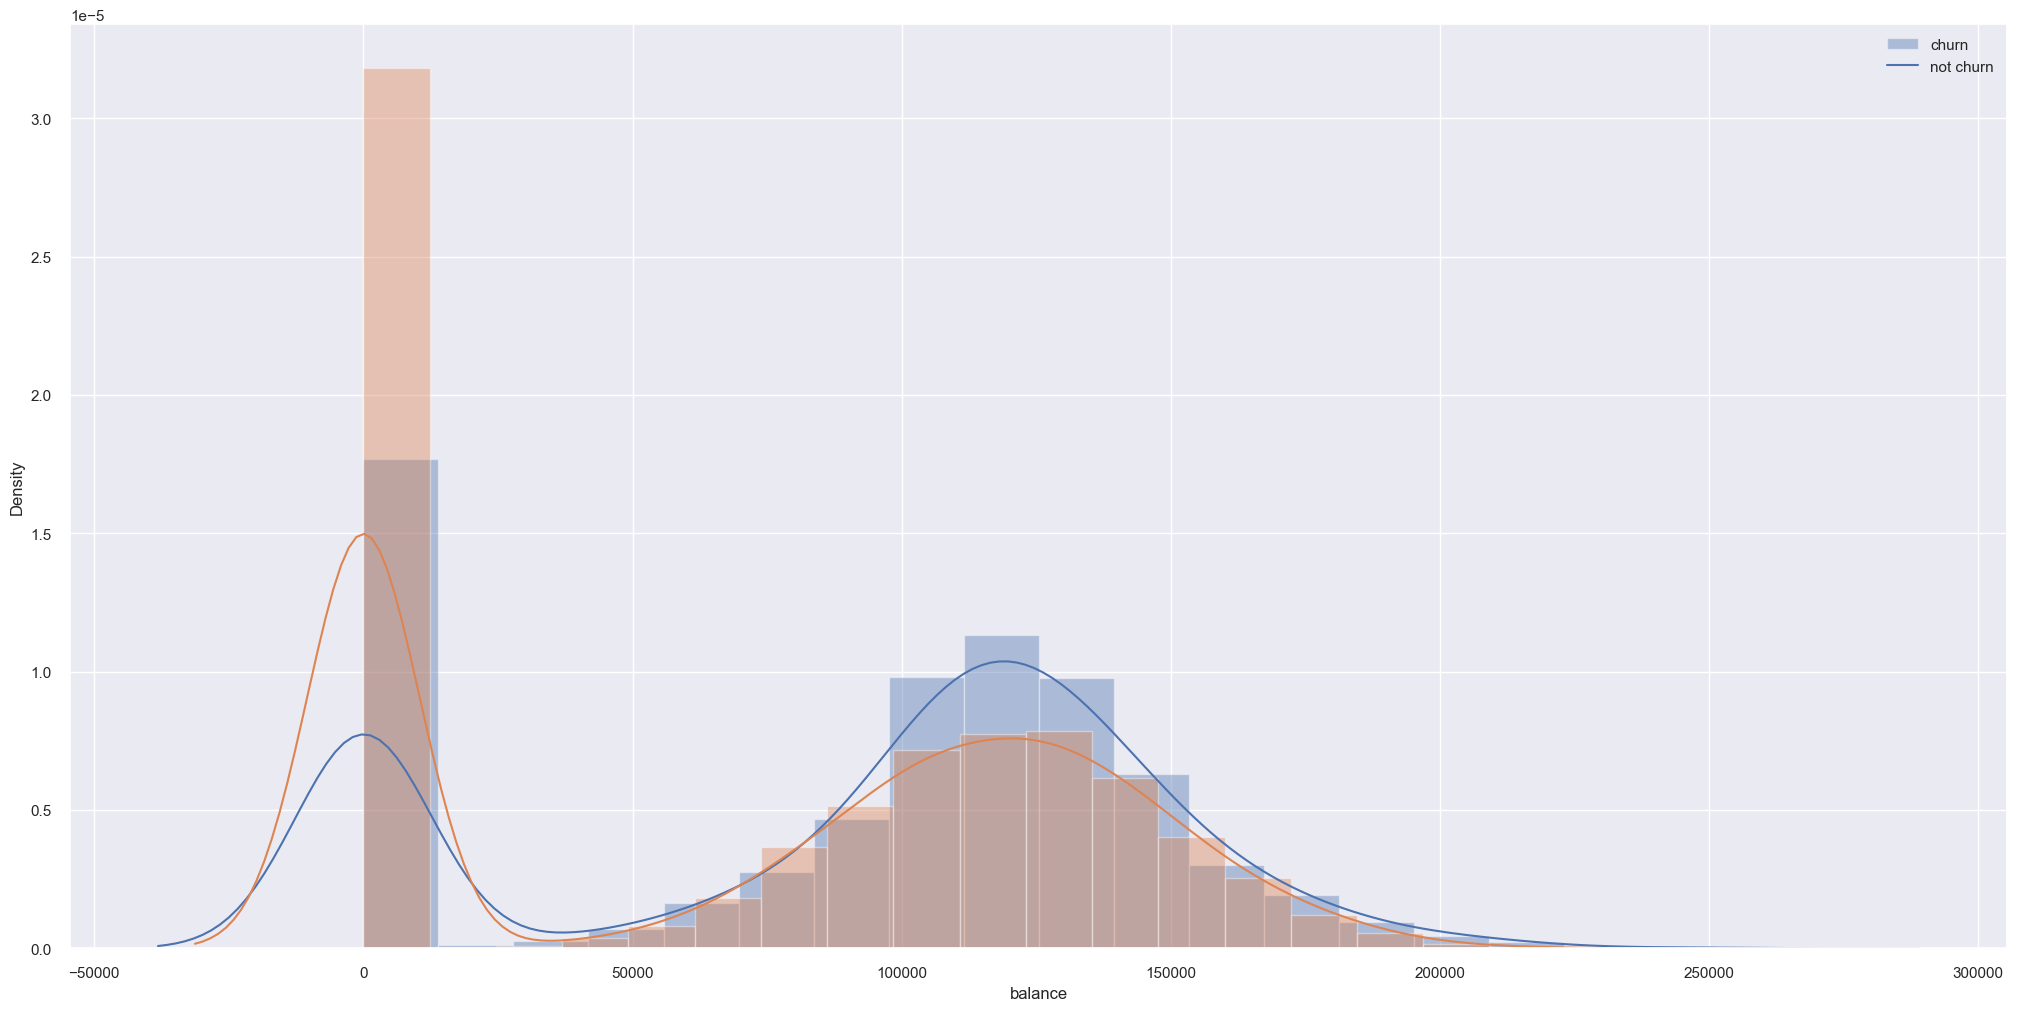

In [26]:
sns.distplot(df4[df4['exited'] == 1]['balance'], label='churn') ;
sns.distplot(df4[df4['exited'] == 0]['balance'], label='not churn') ;
plt.legend(['churn', 'not churn']) ;

### H3. A idade do cliente influencia em possível churn?

### VERDADEIRA. A idade influencia de forma significativa, haja vista que pessoas mais idosas tendem a realizar o churn ( A partir dos 48/49 anos) 

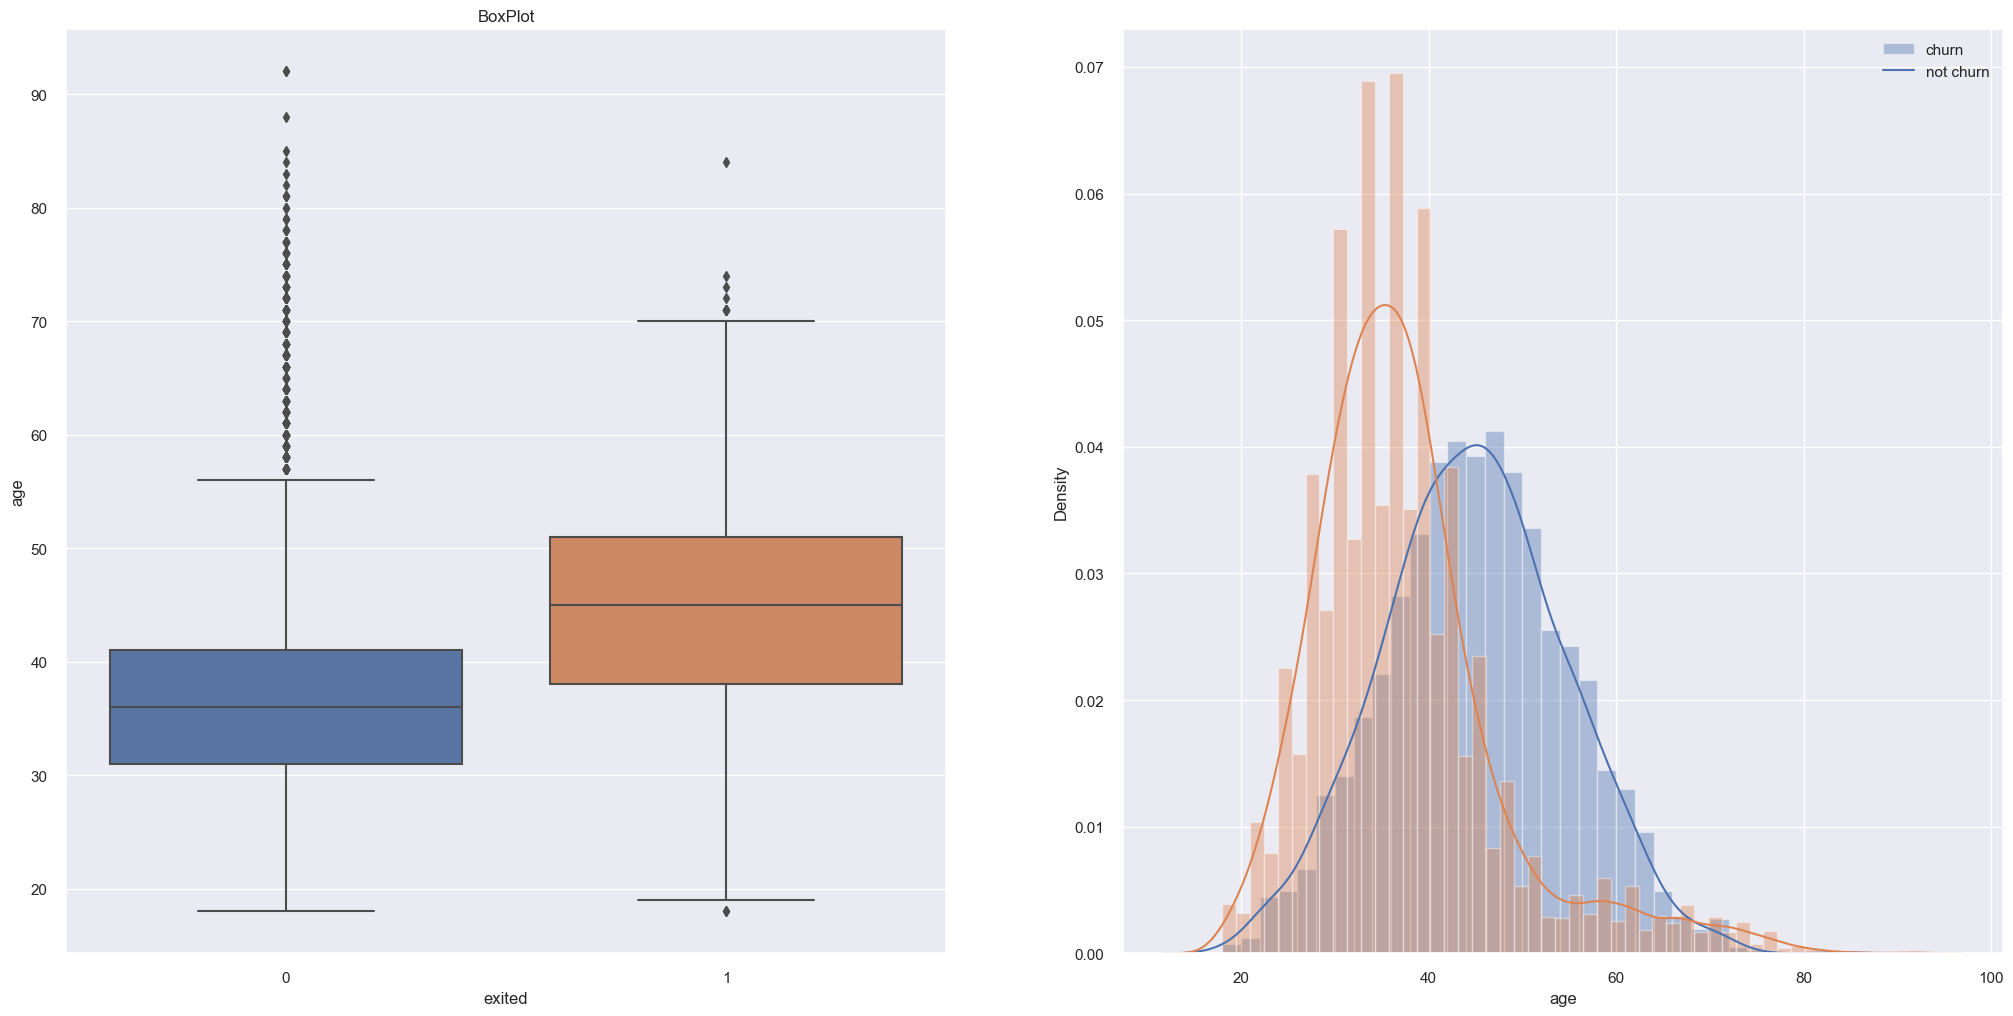

In [27]:
plt.subplot( 1, 2, 1 )
sns.boxplot(x='exited', y='age', data=df4).set_title('BoxPlot') ; 

plt.subplot( 1, 2, 2 )
sns.distplot(df4[df4['exited'] == 1]['age'], label='churn') 
sns.distplot(df4[df4['exited'] == 0]['age'], label='not churn') 
plt.legend(['churn', 'not churn']);

### H4. A tenure do cliente influencia em possível churn?

### VERDADEIRA. Porém, a tenure dos clientes influencia de maneira insuficiente para concluir insights, já que a variação é significativa entre os dados de tenure

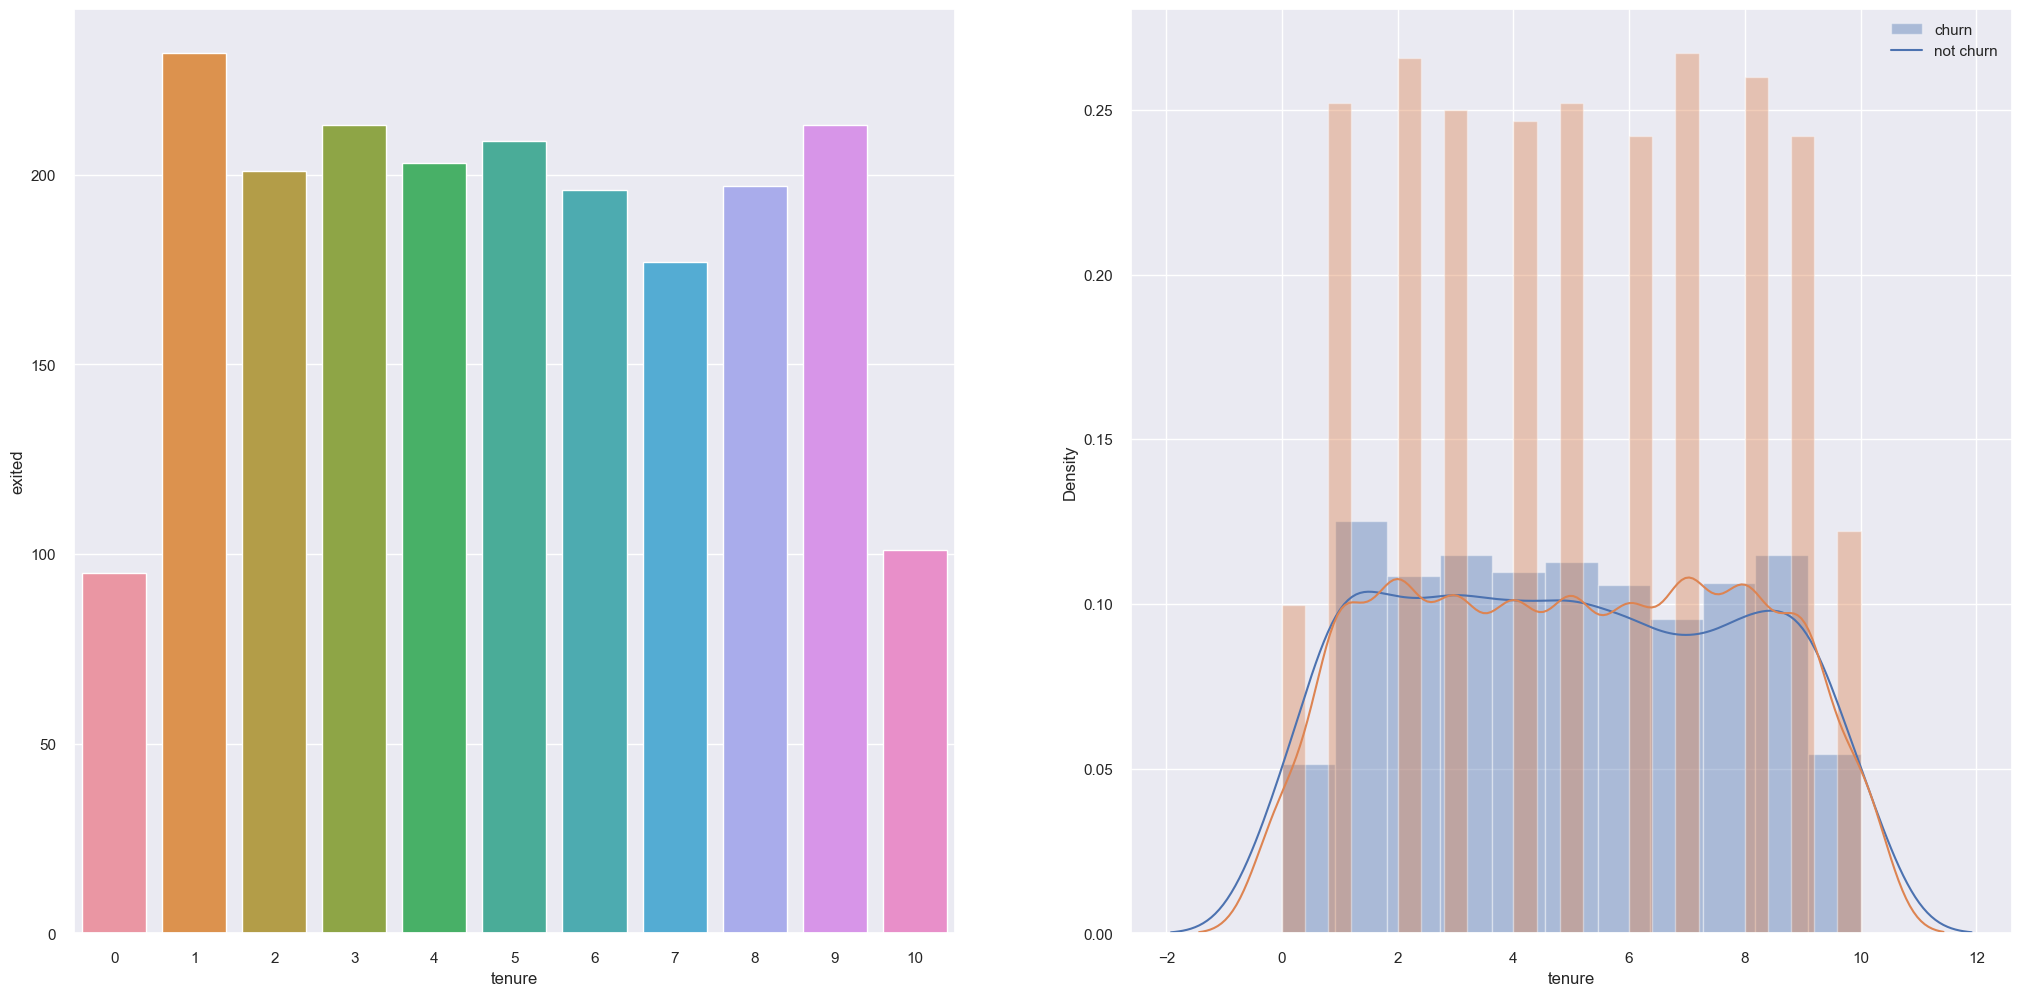

In [28]:
plt.subplot( 1, 2, 1 )
aux1 = df4[['tenure', 'exited']].groupby( 'tenure' ).sum().reset_index()
sns.barplot( x='tenure', y='exited', data=aux1 );

plt.subplot( 1, 2, 2 )
sns.distplot(df4[df4['exited'] == 1]['tenure'], label='churn') 
sns.distplot(df4[df4['exited'] == 0]['tenure'], label='not churn') 
plt.legend(['churn', 'not churn']) ;

### H5. O score do cliente influencia em possível churn?

### FALSA. Não há diferença significativa no churn dos clientes com alto ou baixo score do cartão 

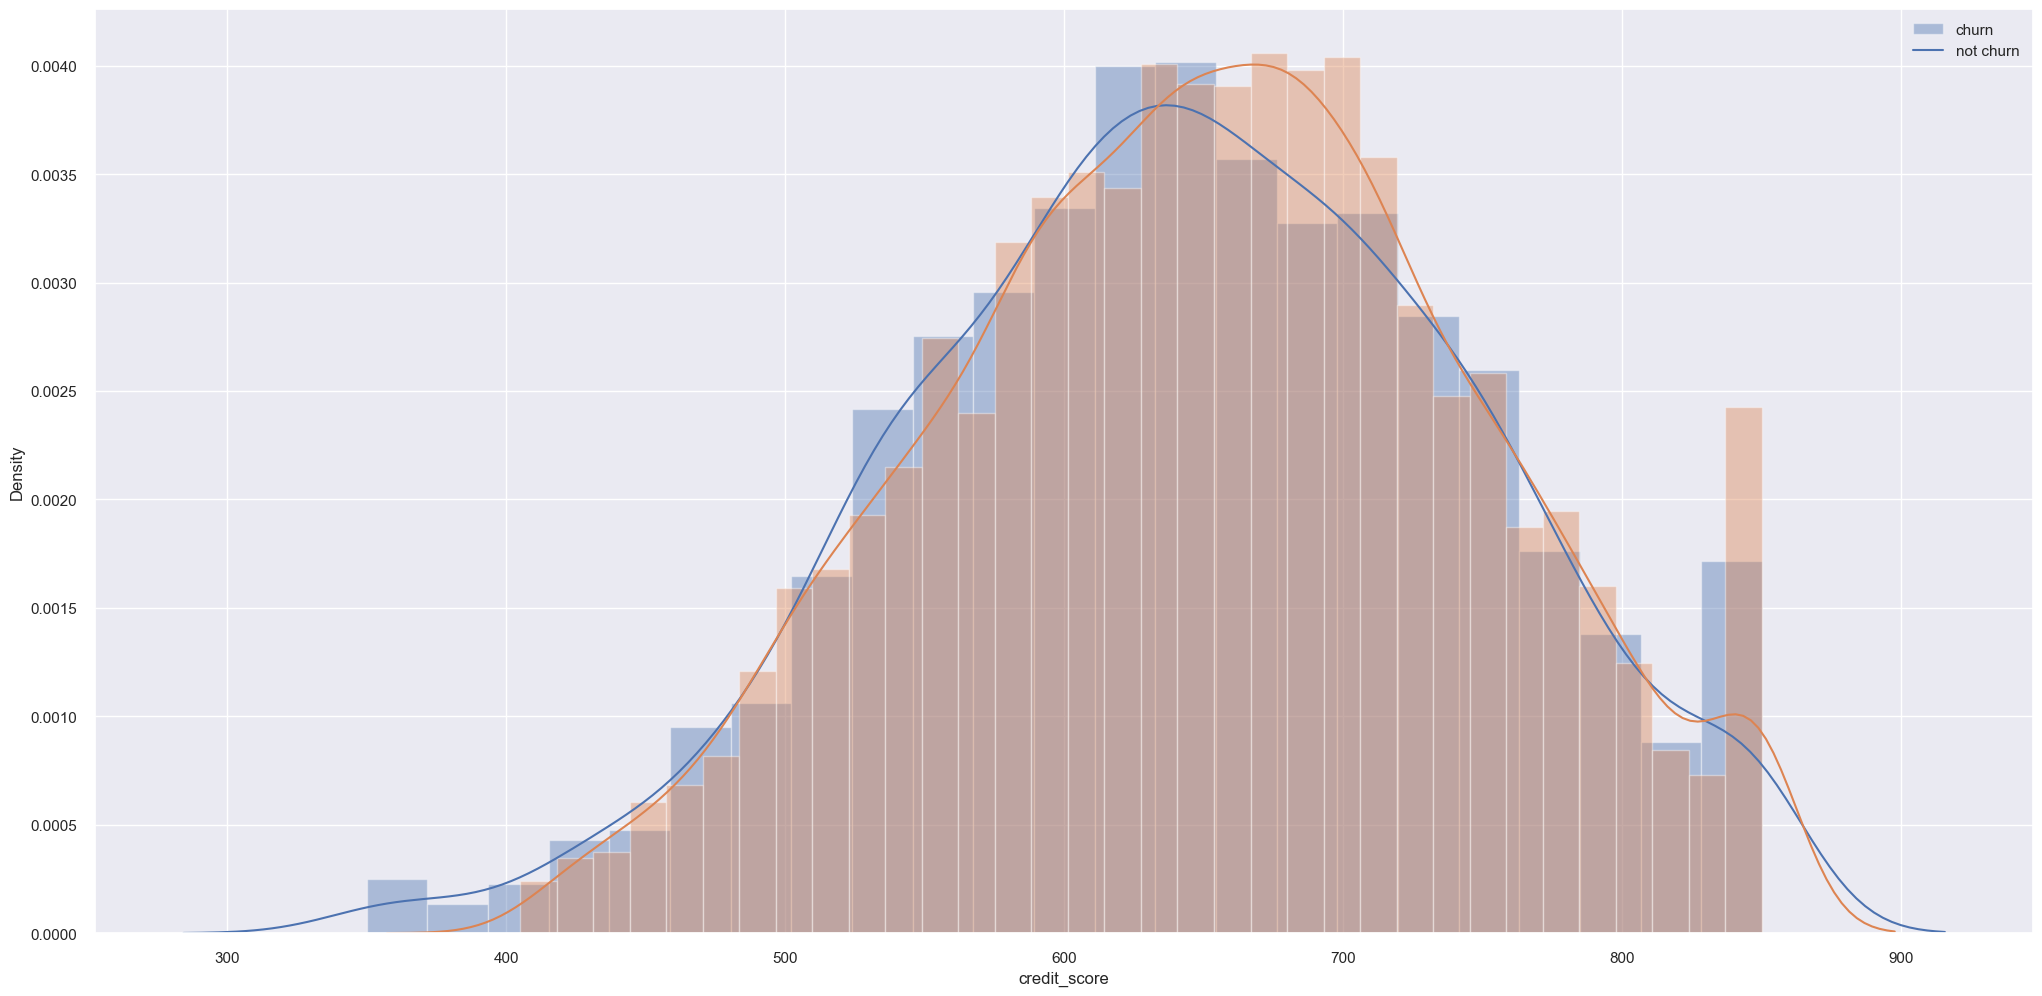

In [29]:
sns.distplot(df4[df4['exited'] == 1]['credit_score'], label='churn')
sns.distplot(df4[df4['exited'] == 0]['credit_score'], label='not churn')
plt.legend(['churn', 'not churn']) ;

### H6. O número de produtos comprados pelo cliente influencia em possível churn?

### VERDADEIRA. O número de produtos influencia em possível churn, haja vista que pessoas com menos produtos tendem a realizar o churn (Churn rate acima da média)

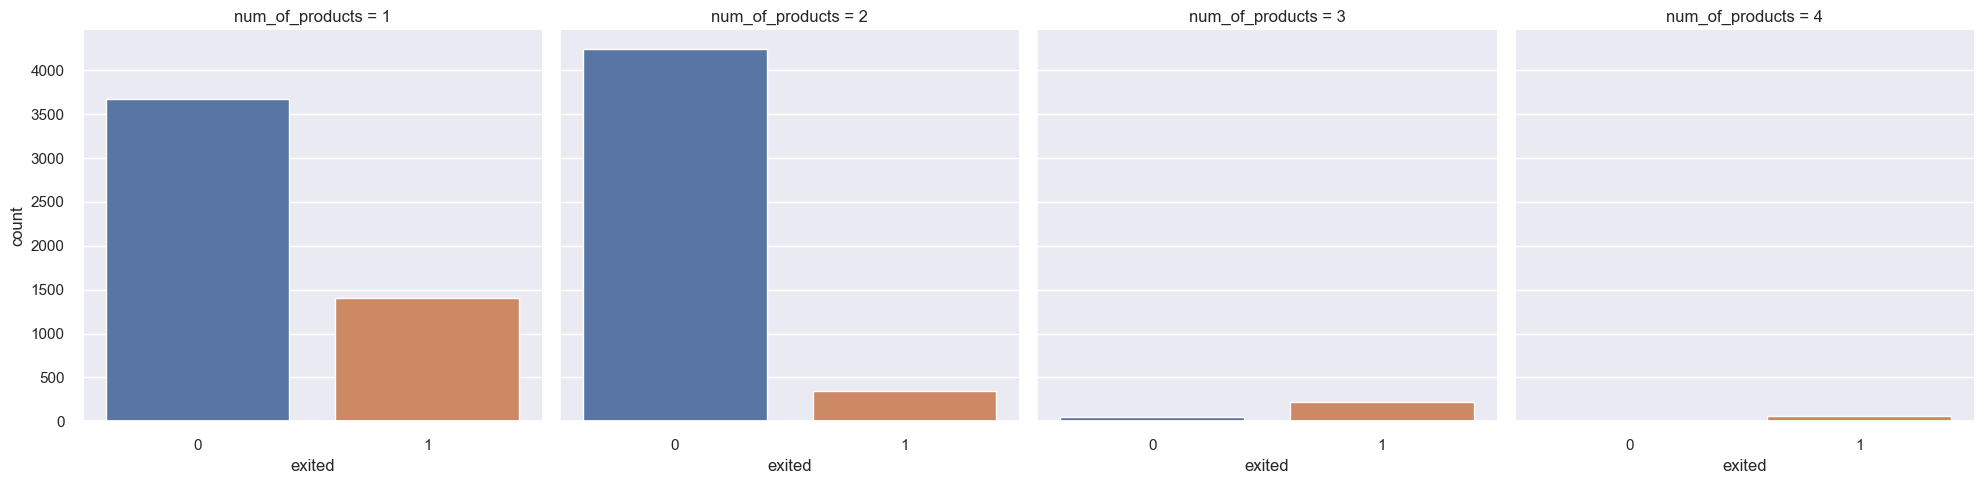

In [30]:
sns.catplot(x='exited', data=df4, kind='count', col='num_of_products', legend=True) ; 

In [ ]:
aux1 = df4[['num_of_products', 'exited']].groupby( 'num_of_products' ).sum().reset_index()
sns.barplot( x='num_of_products', y='exited', data=aux1 );

### 4.2.1 Resumo das Hipóteses

In [31]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Verdadeira', 'Baixa'],
['H2', 'Verdadeira', 'Media'],
['H3', 'Verdadeira', 'Alta'],
['H4', 'Falsa', 'Média'],
['H5', 'Verdadeira', 'Média'],
['H6', 'Verdadeira', 'Alta'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Verdadeira   Baixa
H2           Verdadeira   Media
H3           Verdadeira   Alta
H4           Falsa        Média
H5           Verdadeira   Média
H6           Verdadeira   Alta


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

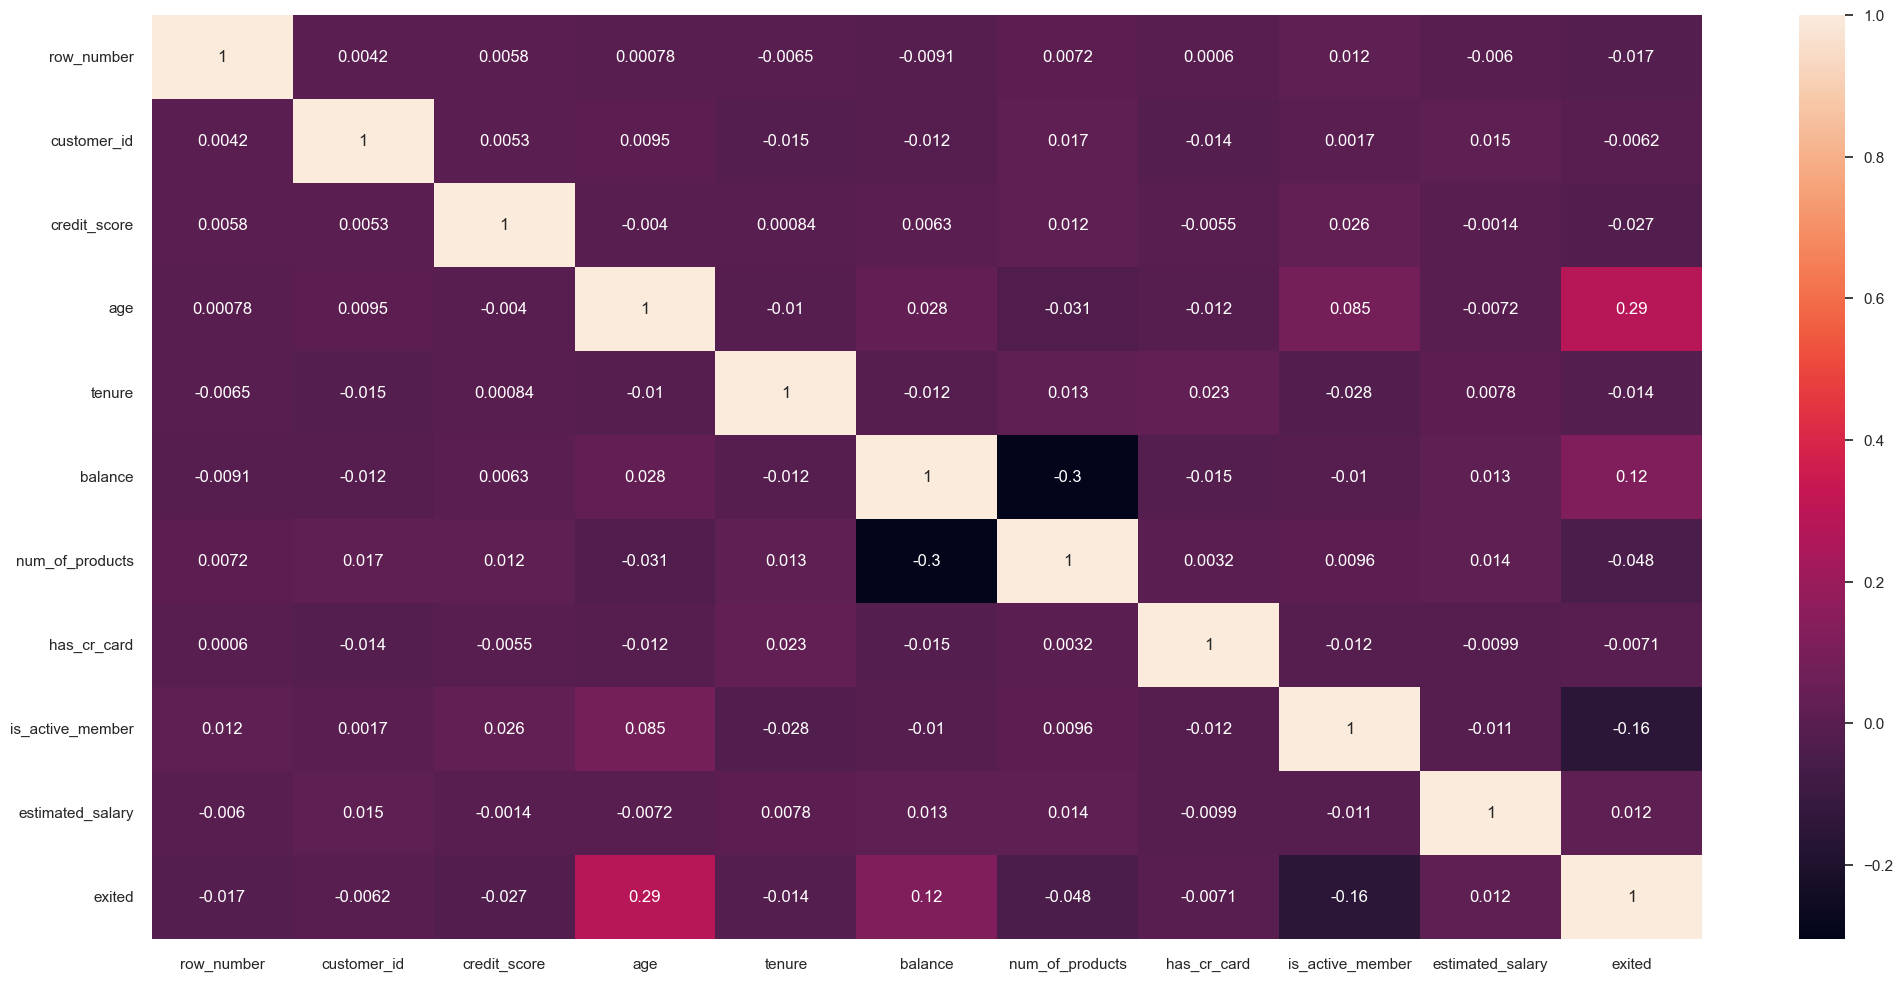

In [32]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

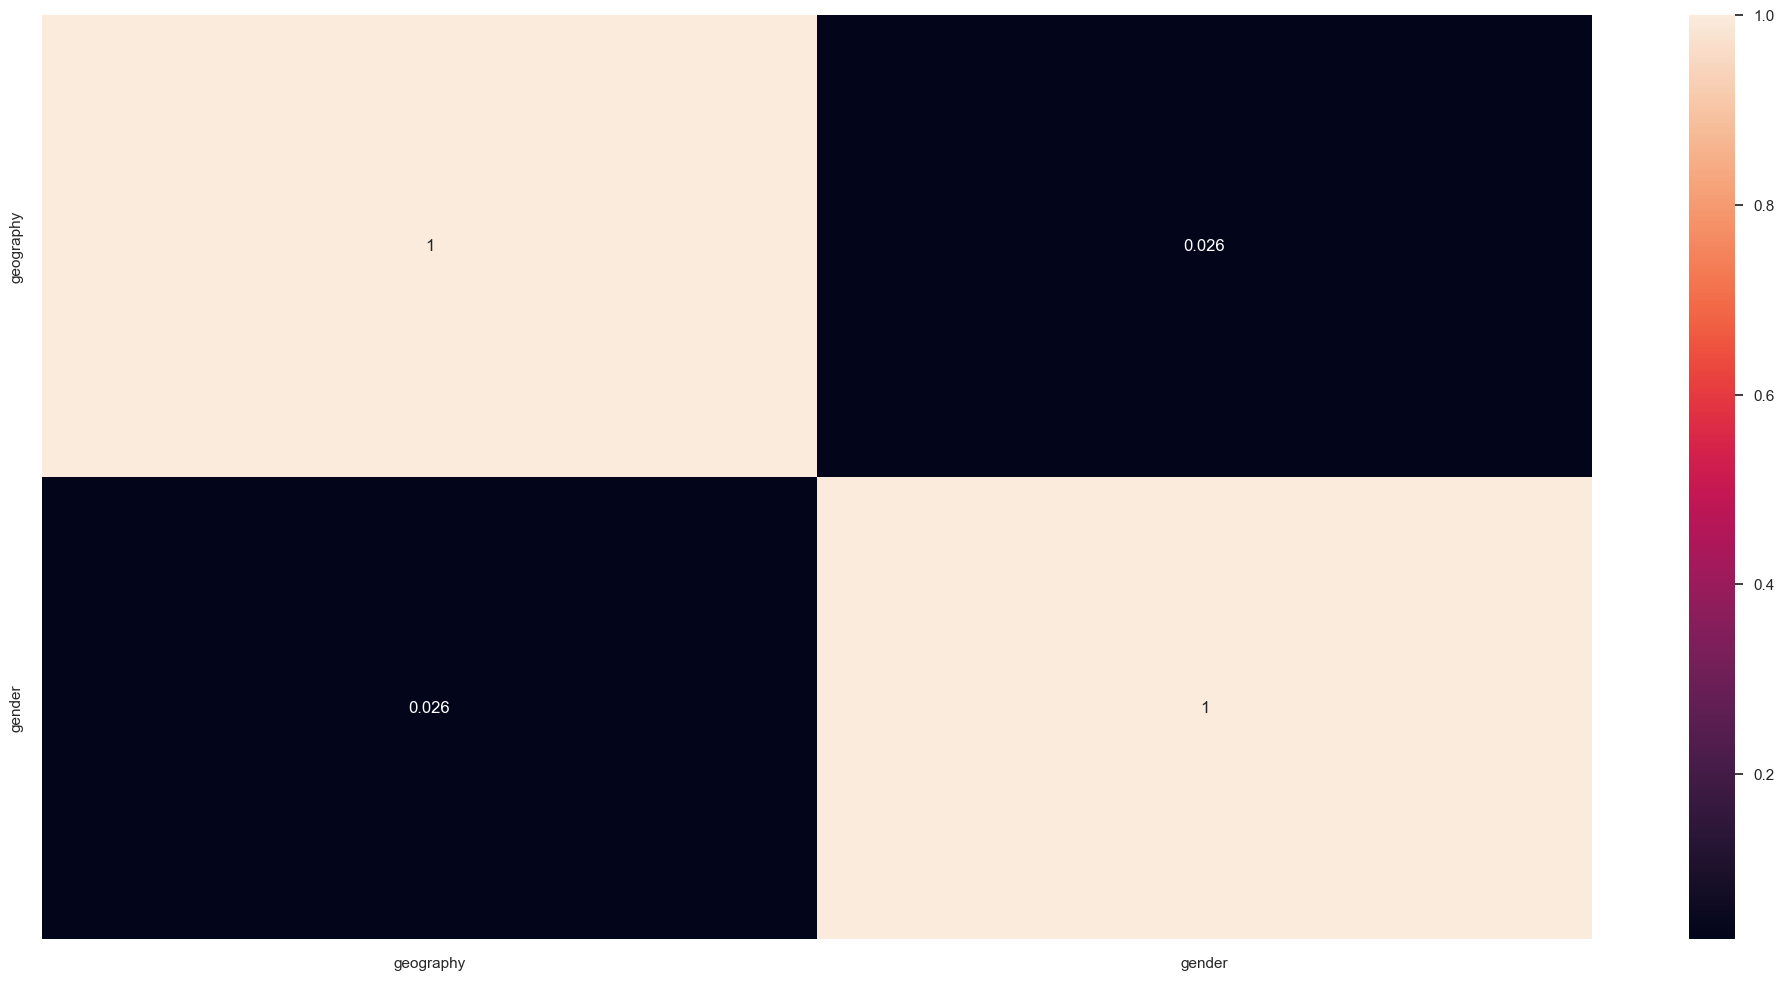

In [33]:
# Selecionando somente Dados Categóricos
cat = df4.select_dtypes(include='object')

# Calcula Cramer V
a1 = cramer_v(cat['geography'], cat['geography'])
a2 = cramer_v(cat['geography'], cat['gender'])

a3 = cramer_v(cat['gender'], cat['geography'])
a4 = cramer_v(cat['gender'], cat['gender'])

# Dataset Final
df = pd.DataFrame({'geography': [a1, a2],
                   'gender': [a3, a4],
                  })
df = df.set_index(df.columns)

# Mapa de Calor para verificar a correlação entre as variáveis categóricas
sns.heatmap(df, annot=True);

# 5.0 Data Preparation

In [34]:
df5 = df4.copy()

In [35]:
X = df5.drop('exited', axis=1)
y = df5['exited'].copy()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

df5 = pd.concat([X_train, y_train], axis=1)

## 5.1 Normalização

- Não há variáveis com distribuição normal no dataset

## 5.2 Rescaling

In [36]:
mms_bl = MinMaxScaler()
mms_es = MinMaxScaler()
mms_em = MinMaxScaler()
mms_te = MinMaxScaler()
mms_cs = MinMaxScaler()
mms_ag = MinMaxScaler()

# credit_score
df5['credit_score'] = mms_cs.fit_transform( df5[['credit_score']].values )
pickle.dump( mms_cs, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/parameter/credit_score.pkl', 'wb') )

# balance
df5['balance'] = mms_bl.fit_transform(df5[['balance']].values )
pickle.dump( mms_bl, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/parameter/balance.pkl', 'wb') )

# estimated_salary
df5['estimated_salary'] = mms_es.fit_transform( df5[['estimated_salary']].values )
pickle.dump( mms_es, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/parameter/estimated_salary.pkl', 'wb') )

# estimated_monthly_salary
df5['estimated_monthly_salary'] = mms_em.fit_transform( df5[['estimated_monthly_salary']].values )
pickle.dump( mms_em, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/parameter/estimated_monthly_salary.pkl', 'wb') )

# tenure
df5['tenure'] = mms_te.fit_transform( df5[['tenure']].values )
pickle.dump( mms_te, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/parameter/tenure.pkl', 'wb') )

# age
df5['age'] = mms_ag.fit_transform( df5[['age']].values )
pickle.dump( mms_ag, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/parameter/age.pkl', 'wb') )

## 5.3 Transformação

### 5.3.1 Encoding

In [37]:
# gender - Label Encoding
le_gender = LabelEncoder()
df5['gender'] = le_gender.fit_transform( df5['gender'] )
pickle.dump( le_gender, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/parameter/gender.pkl', 'wb') )

# geography - One hot Encoding
df5 = pd.get_dummies( df5, prefix=['geography'], columns=['geography'] )

# 6.0 Feature Selection

In [40]:
df6 = df5.copy()

## 6.1 Balancing data - Undersampling and Oversampling

In [41]:
X_res, y_res = SMOTETomek(random_state=42).fit_resample(df6.drop(columns=['exited'], axis=1), df6['exited'])

In [42]:
# Antes do balanceamento
print(y_train.value_counts())

0    6356
1    1644
Name: exited, dtype: int64


In [43]:
# Depois do balanceamento
print(y_res.value_counts())

0    6185
1    6185
Name: exited, dtype: int64


In [44]:
X_train = X_res
y_train = y_res

## 6.2 Test Data Preparation

In [45]:
# credit_score
X_test['credit_score'] = mms_cs.transform( X_test[['credit_score']].values )
#pickle.dump( mms_cs, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/parameter/credit_score.pkl', 'wb') )

# balance
X_test['balance'] = mms_bl.transform(X_test[['balance']].values )
#pickle.dump( mms_bl, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/parameter/balance.pkl', 'wb') )

# estimated_salary
X_test['estimated_salary'] = mms_es.transform( X_test[['estimated_salary']].values )
#pickle.dump( mms_es, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/parameter/estimated_salary.pkl', 'wb') )

# estimated_monthly_salary
X_test['estimated_monthly_salary'] = mms_em.transform( X_test[['estimated_monthly_salary']].values )
#pickle.dump( mms_em, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/parameter/estimated_monthly_salary.pkl', 'wb') )

# tenure
X_test['tenure'] = mms_te.transform( X_test[['tenure']].values )
#pickle.dump( mms_te, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/parameter/tenure.pkl', 'wb') )

# age
X_test['age'] = mms_ag.transform( X_test[['age']].values )
#pickle.dump( mms_ag, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/parameter/age.pkl', 'wb') )

# gender - Label Encoding
X_test['gender'] = le_gender.transform( X_test['gender'] )
#pickle.dump( le_gender, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/parameter/gender.pkl', 'wb') )

# geography - One hot Encoding
X_test = pd.get_dummies( X_test, prefix=['geography'], columns=['geography'] )

## 6.3 Ranking Best Features

Feature ranking:
                    feature  importance
0                       age    0.146862
0           num_of_products    0.131651
0                    tenure    0.086635
0              credit_score    0.082523
0          estimated_salary    0.078206
0  estimated_monthly_salary    0.078144
0                   balance    0.073921
0                  high_age    0.056479
0          is_active_member    0.049569
0              low_products    0.032221
0             high_products    0.031558
0                    gender    0.029301
0               has_cr_card    0.026750
0            medium_balance    0.026230
0         geography_Germany    0.024751
0              null_balance    0.019878
0          geography_France    0.014205
0           geography_Spain    0.011117


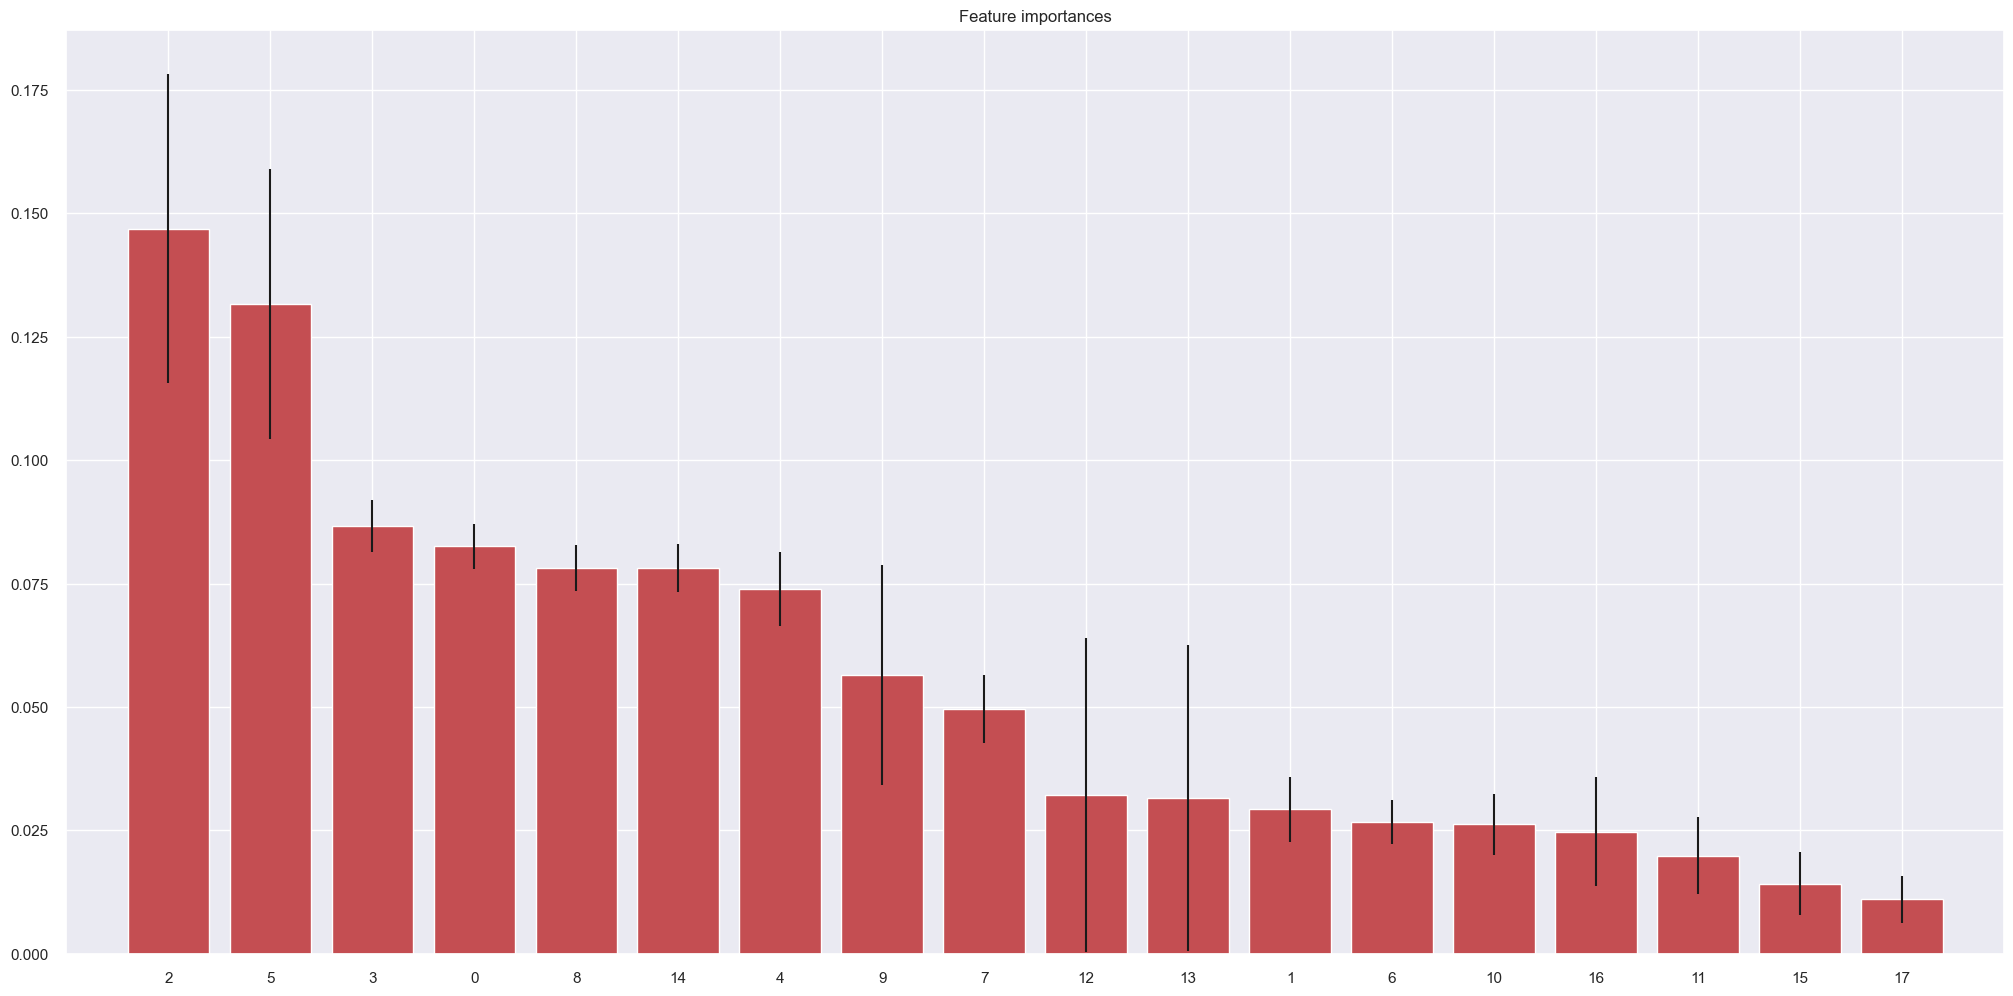

In [46]:
# Training model to rank features

forest = en.ExtraTreesClassifier(n_estimators=250, random_state=42, n_jobs=-1)
x_train_f = X_train
y_train_f = y_train.values
forest.fit(x_train_f, y_train_f)

# Collect features from model selector
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Organize and print ranking per features
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_f, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(x_train_f.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_f.shape[1]), indices)
plt.xlim([-1, x_train_f.shape[1]])
plt.show()

## 6.4 Boruta as Feature Selector

In [46]:
# training and test dataset for Boruta
# X_train_n = X_train.values
# y_train_n = y_train.values.ravel()

# define RandomForestRegressor
# rf = en.RandomForestClassifier( n_jobs=-1 )

# define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

### 6.4.1 Best Features from Boruta

In [47]:
#cols_selected = boruta.support_.tolist()

#cols_selected

In [48]:
cols_selected_boruta = [
'age',
'balance',
'num_of_products',
'credit_score']

# 7.0 Machine Learning Model Selection

In [47]:
# select features from ML
cols_selected = ['tenure', 'balance', 'age', 'estimated_salary',
                'estimated_monthly_salary', 'credit_score', 'num_of_products', 'high_age', 'is_active_member'] 

# Dataframe for ML
X_train = X_train[cols_selected]
X_test = X_test[cols_selected]

## 7.1 Logistic Regression 

In [48]:
# model
logr = LogisticRegression().fit( X_train, y_train )

# prediction
yhat_logr = logr.predict( X_test )
y_proba_logr = logr.predict_proba( X_test )

# performance
lgr_result = ml_acc('Logistic Regression', y_test, yhat_logr)

### 7.1.1 Logistic Regression Score

In [49]:
lgr_result

,Model Name,Accuracy,f1_score,Recall,Precision
0,Logistic Regression,0.6995,0.474191,0.689567,0.361333


### 7.1.2 Logistic Regression Model - Cross Validation

In [50]:
lgr_result_cv = cross_validation( 'Logistic Regression', logr, X_train, y_train, 5, verbose=False )
lgr_result_cv

,Precision @k - CV,Recall @k - CV,Accuracy - CV,F1_score - CV
Logistic Regression,0.567,0.003,0.698,0.689


## 7.2 Random Forest Classifier 

In [51]:
# model
rfc = RandomForestClassifier(max_depth=9, n_estimators=600, random_state=42)
rfc.fit(X_train, y_train)

# prediction
yhat_rfc = rfc.predict( X_test )
y_proba_rfc = rfc.predict_proba( X_test )

# performance
rfc_result = ml_acc('Random Forest Classifier', y_test, yhat_rfc)

### 7.2.1 Random Forest Classifier Score

In [52]:
rfc_result

,Model Name,Accuracy,f1_score,Recall,Precision
0,Random Forest Classifier,0.797,0.568085,0.679389,0.488117


### 7.2.2 Random Forest Classifier Model - Cross Validation

In [53]:
rfc_result_cv = cross_validation( 'Random Forest Classifier', rfc, X_train, y_train, 5, verbose=False )
rfc_result_cv

,Precision @k - CV,Recall @k - CV,Accuracy - CV,F1_score - CV
Random Forest Classifier,1.0,0.005,0.833,0.829


## 7.3 Extra Trees Classifier

In [54]:
# model definition
et_model = en.ExtraTreesClassifier(n_estimators = 600, n_jobs=-1, random_state=42)

# model fit
et_model.fit(X_train, y_train)

# model prediction
y_hat_et = et_model.predict(X_test)
y_proba_etc = et_model.predict_proba( X_test )

# performance
etc_result = ml_acc('Extra Trees Classifier', y_test, y_hat_et)

### 7.3.1 Extra Trees Classifier Score

In [55]:
etc_result

,Model Name,Accuracy,f1_score,Recall,Precision
0,Extra Trees Classifier,0.812,0.553444,0.592875,0.518931


### 7.3.2 Extra Trees Classifier Model - Cross Validation

In [56]:
etc_result_cv = cross_validation( 'Extra Trees Classifier', et_model, X_train, y_train, 5, verbose=False )
etc_result_cv

,Precision @k - CV,Recall @k - CV,Accuracy - CV,F1_score - CV
Extra Trees Classifier,1.0,0.005,0.887,0.888


## 7.4 ANN

In [57]:
ann = tf.keras.models.Sequential()

ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
387/387 [==============================] - 0s 402us/step - loss: 0.6612 - accuracy: 0.6054
Epoch 2/100
387/387 [==============================] - 0s 329us/step - loss: 0.6048 - accuracy: 0.6751
Epoch 3/100
387/387 [==============================] - 0s 328us/step - loss: 0.5925 - accuracy: 0.6794
Epoch 4/100
387/387 [==============================] - 0s 341us/step - loss: 0.5830 - accuracy: 0.6822
Epoch 5/100
387/387 [==============================] - 0s 329us/step - loss: 0.5733 - accuracy: 0.6864
Epoch 6/100
387/387 [==============================] - 0s 322us/step - loss: 0.5614 - accuracy: 0.6991
Epoch 7/100
387/387 [==============================] - 0s 322us/step - loss: 0.5496 - accuracy: 0.7108
Epoch 8/100
387/387 [==============================] - 0s 324us/step - loss: 0.5363 - accuracy: 0.7184
Epoch 9/100
387/387 [==============================] - 0s 324us/step - loss: 0.5244 - accuracy: 0.7271
Epoch 10/100
387/387 [==============================] - 0s 324us/step - l

387/387 [==============================] - 0s 354us/step - loss: 0.4506 - accuracy: 0.7783
Epoch 80/100
387/387 [==============================] - 0s 331us/step - loss: 0.4509 - accuracy: 0.7820
Epoch 81/100
387/387 [==============================] - 0s 355us/step - loss: 0.4508 - accuracy: 0.7804
Epoch 82/100
387/387 [==============================] - 0s 328us/step - loss: 0.4509 - accuracy: 0.7786
Epoch 83/100
387/387 [==============================] - 0s 332us/step - loss: 0.4502 - accuracy: 0.7787
Epoch 84/100
387/387 [==============================] - 0s 359us/step - loss: 0.4509 - accuracy: 0.7804
Epoch 85/100
387/387 [==============================] - 0s 337us/step - loss: 0.4500 - accuracy: 0.7809
Epoch 86/100
387/387 [==============================] - 0s 330us/step - loss: 0.4496 - accuracy: 0.7814
Epoch 87/100
387/387 [==============================] - 0s 330us/step - loss: 0.4503 - accuracy: 0.7825
Epoch 88/100
387/387 [==============================] - 0s 331us/step - loss:

In [58]:
# prediction
yhat_ann = ann.predict( X_test )

63/63 [==============================] - 0s 288us/step


## 7.5 XGBoost Classifier

In [59]:
n = (y_train.shape[0] - y_train.sum())/y_train.sum()
# model definition
xgb_model = xgb.XGBClassifier(n_estimators = 600 ,scale_pos_weight=n, random_state=42 )

# model fit
xgb_model.fit(X_train, y_train)

# model prediction
y_hat_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba( X_test )

# performance
xgb_result = ml_acc('XGBoost Classifier', y_test, y_hat_xgb)

### 7.5.1 XGBoost Classifier Score

In [61]:
xgb_result

,Model Name,Accuracy,f1_score,Recall,Precision
0,XGBoost Classifier,0.851,0.570605,0.503817,0.657807


### 7.5.2 XGBoost Classifier Model - Cross Validation

In [62]:
xgb_result_cv = cross_validation( 'XGBoost Classifier', xgb_model, X_train, y_train, 5, verbose=False )
xgb_result_cv

,Precision @k - CV,Recall @k - CV,Accuracy - CV,F1_score - CV
XGBoost Classifier,1.0,0.005,0.899,0.894


## 7.6 KNN

In [63]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=10)

# model training
knn_model.fit(X_train, y_train)

# model prediction
y_hat_knn = knn_model.predict(X_test)
y_proba_knn = knn_model.predict_proba( X_test )

# performance
knn_result = ml_acc('KNN', y_test, y_hat_knn)

### 7.6.1 KNN Score

In [64]:
knn_result

,Model Name,Accuracy,f1_score,Recall,Precision
0,KNN,0.749,0.519157,0.689567,0.416283


### 7.6.2 KNN Model - Cross Validation

In [65]:
knn_result_cv = cross_validation( 'KNN', knn_model, X_train, y_train, 5, verbose=False )
knn_result_cv

,Precision @k - CV,Recall @k - CV,Accuracy - CV,F1_score - CV
KNN,0.967,0.005,0.802,0.804


## 7.7 Compare Model's Performance

### 7.7.1. Single Performance

In [67]:
modelling_result = pd.concat( [lgr_result, rfc_result, etc_result, xgb_result, knn_result] )
modelling_result.sort_values('Precision', ascending=False)

,Model Name,Accuracy,f1_score,Recall,Precision
0,XGBoost Classifier,0.8510,0.570605,0.503817,0.657807
0,Extra Trees Classifier,0.8120,0.553444,0.592875,0.518931
0,Random Forest Classifier,0.7970,0.568085,0.679389,0.488117
0,KNN,0.7490,0.519157,0.689567,0.416283
0,Logistic Regression,0.6995,0.474191,0.689567,0.361333


### 7.7.2. Real Performance - Cross Validation

In [68]:
modelling_result_cv = pd.concat( [lgr_result_cv, rfc_result_cv, etc_result_cv, xgb_result_cv, knn_result_cv] )
modelling_result_cv.sort_values('F1_score - CV', ascending=False)

,Precision @k - CV,Recall @k - CV,Accuracy - CV,F1_score - CV
XGBoost Classifier,1.000,0.005,0.899,0.894
Extra Trees Classifier,1.000,0.005,0.887,0.888
Random Forest Classifier,1.000,0.005,0.833,0.829
KNN,0.967,0.005,0.802,0.804
Logistic Regression,0.567,0.003,0.698,0.689


# 8.0 Hyperparameter Fine Tuning

## 8.1 Grid Search Model

### 8.1.1 XGBoost Classifier

In [69]:
#rf_params = {
#    'n_estimators': [100, 300, 500, 600],
    #'max_features': ['sqrt',0.5],
#    'max_depth': [5, 7, 9, 11, 13, 15],
#    'min_samples_leaf': [1, 3, 5, 7],
    #"bootstrap":[True,False],
#}
#clf = xgb.XGBClassifier(random_state=42)
#grid = GridSearchCV(clf, rf_params, cv=3, scoring='f1')
#grid.fit(X_train, y_train)
#print(grid.best_params_)
#print("f1_score:"+ str(grid.best_score_))

### 8.1.2 Transforming df4 data to build df_prob for future analysis

In [70]:
# credit_score
df4['credit_score'] = mms_cs.fit_transform( df4[['credit_score']].values )

# balance
df4['balance'] = mms_bl.fit_transform(df4[['balance']].values )

# estimated_salary
df4['estimated_salary'] = mms_es.fit_transform( df4[['estimated_salary']].values )

# estimated_monthly_salary
df4['estimated_monthly_salary'] = mms_em.fit_transform( df4[['estimated_monthly_salary']].values )

# tenure
df4['tenure'] = mms_te.fit_transform( df4[['tenure']].values )

# age
df4['age'] = mms_ag.fit_transform( df4[['age']].values )

df4['gender'] = le_gender.fit_transform( df4['gender'] )

df4 = pd.get_dummies( df4, prefix=['geography'], columns=['geography'] )

### 8.1.3 Final Model

In [71]:
n = (y_train.shape[0] - y_train.sum())/y_train.sum()
# model definition
xgb_model_tuned = xgb.XGBClassifier(n_estimators = 600 , scale_pos_weight = n, max_depth = 9, min_samples_leaf = 1, random_state = 42 )

# model fit
xgb_model_tuned.fit(X_train, y_train)

# model prediction
y_hat_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba( X_test )
prob_xgb_full = xgb_model.predict_proba(df4[X_test.columns])[:,1]

# performance
xgb_result_tuned = ml_acc('XGBoost Classifier', y_test, y_hat_xgb)
xgb_result_tuned

,Model Name,Accuracy,f1_score,Recall,Precision
0,XGBoost Classifier,0.8495,0.566906,0.501272,0.652318


# 9.0 Results Interpretation

In [72]:
df_prob = df2.copy()

df_prob['prob'] = prob_xgb_full

## 9.1 Graphs Visualization

### 9.1.1 ROC AUC Curve

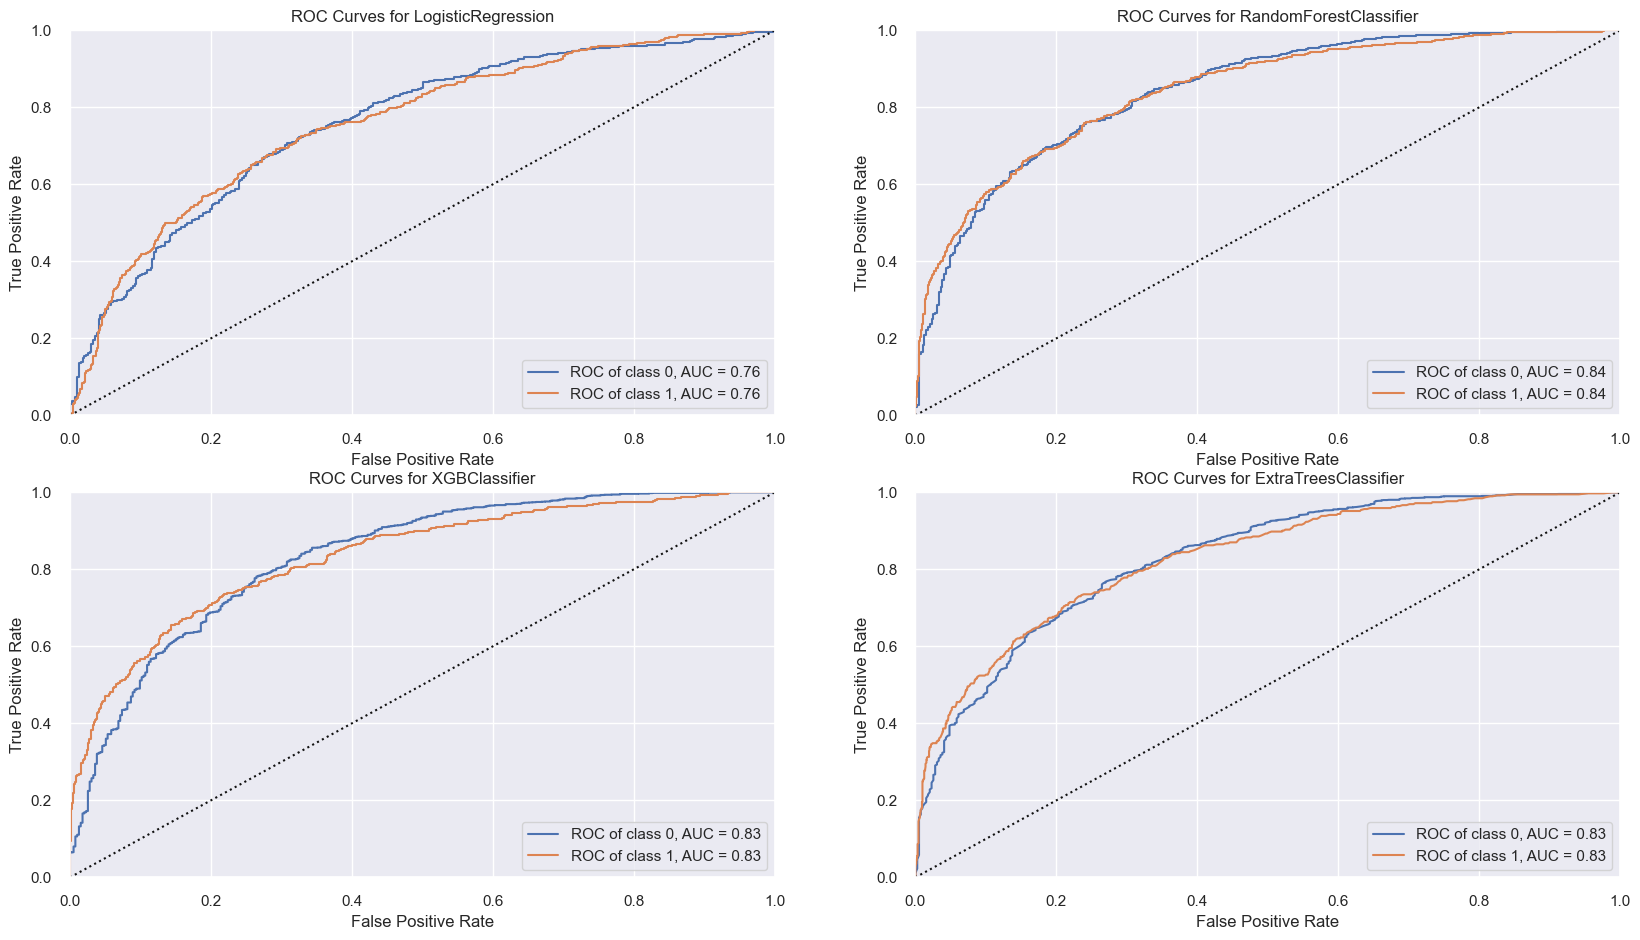

In [73]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 11))

viz = ROCAUC(logr, iso_f1_curves=True, micro=False, macro=False, ax=ax1)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = ROCAUC(rfc, iso_f1_curves=True, micro=False, macro=False, ax=ax2)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = ROCAUC(xgb_model, iso_f1_curves=True, micro=False, macro=False, ax=ax3)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = ROCAUC(et_model, iso_f1_curves=True, micro=False, macro=False, ax=ax4)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

### 9.1.2 Confusion Matrix Visualization

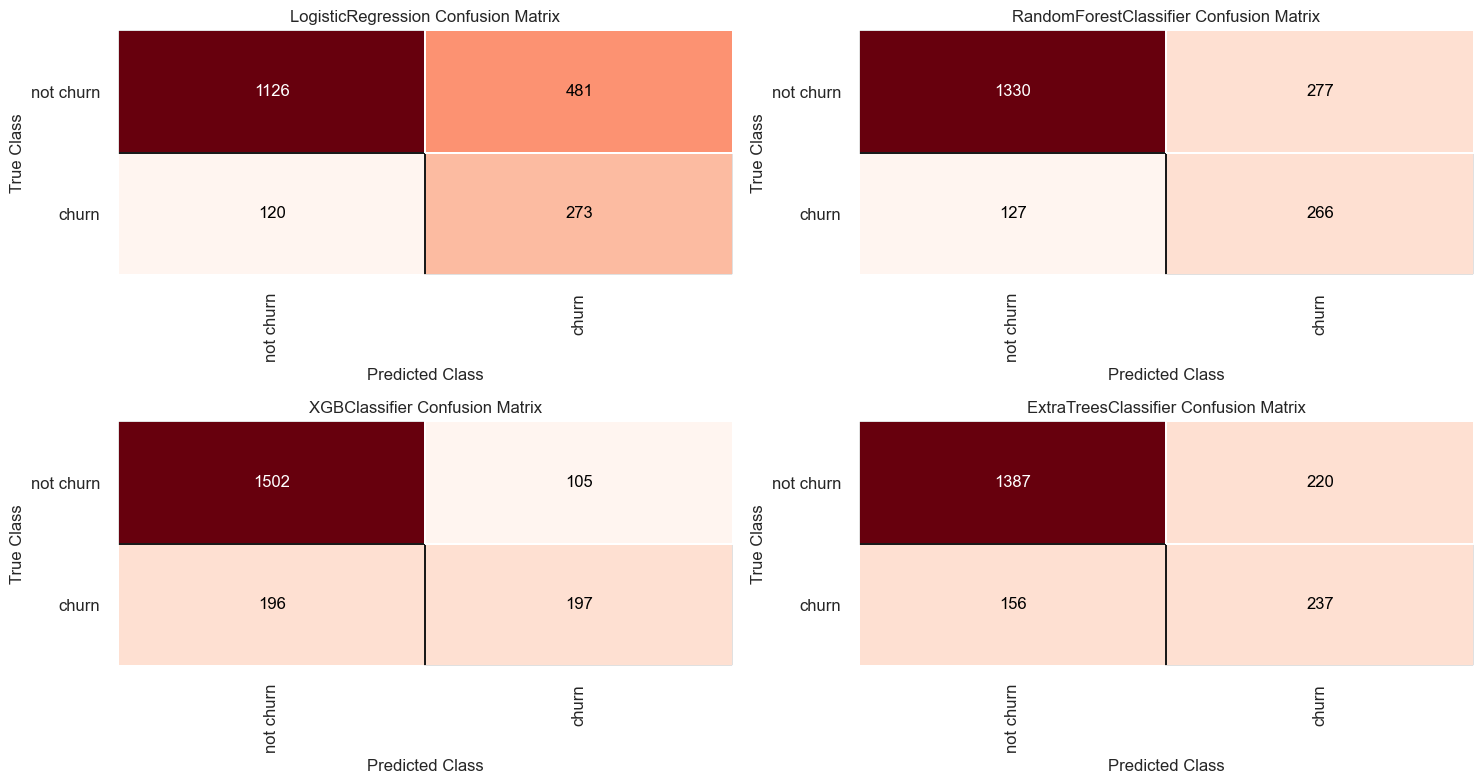

In [74]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15, 8))

visualizer = ConfusionMatrix(logr, classes=['not churn', 'churn'], support=True, ax=ax1, cmap='Reds')
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

visualizer = ConfusionMatrix(rfc, classes=['not churn', 'churn'], support=True, ax=ax2, cmap='Reds')
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

visualizer = ConfusionMatrix(xgb_model, classes=['not churn', 'churn'], support=True, ax=ax3, cmap='Reds')
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

visualizer = ConfusionMatrix(et_model, classes=['not churn', 'churn'], support=True, ax=ax4, cmap='Reds')
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

### 9.1.3 PrecisionRecall Curve

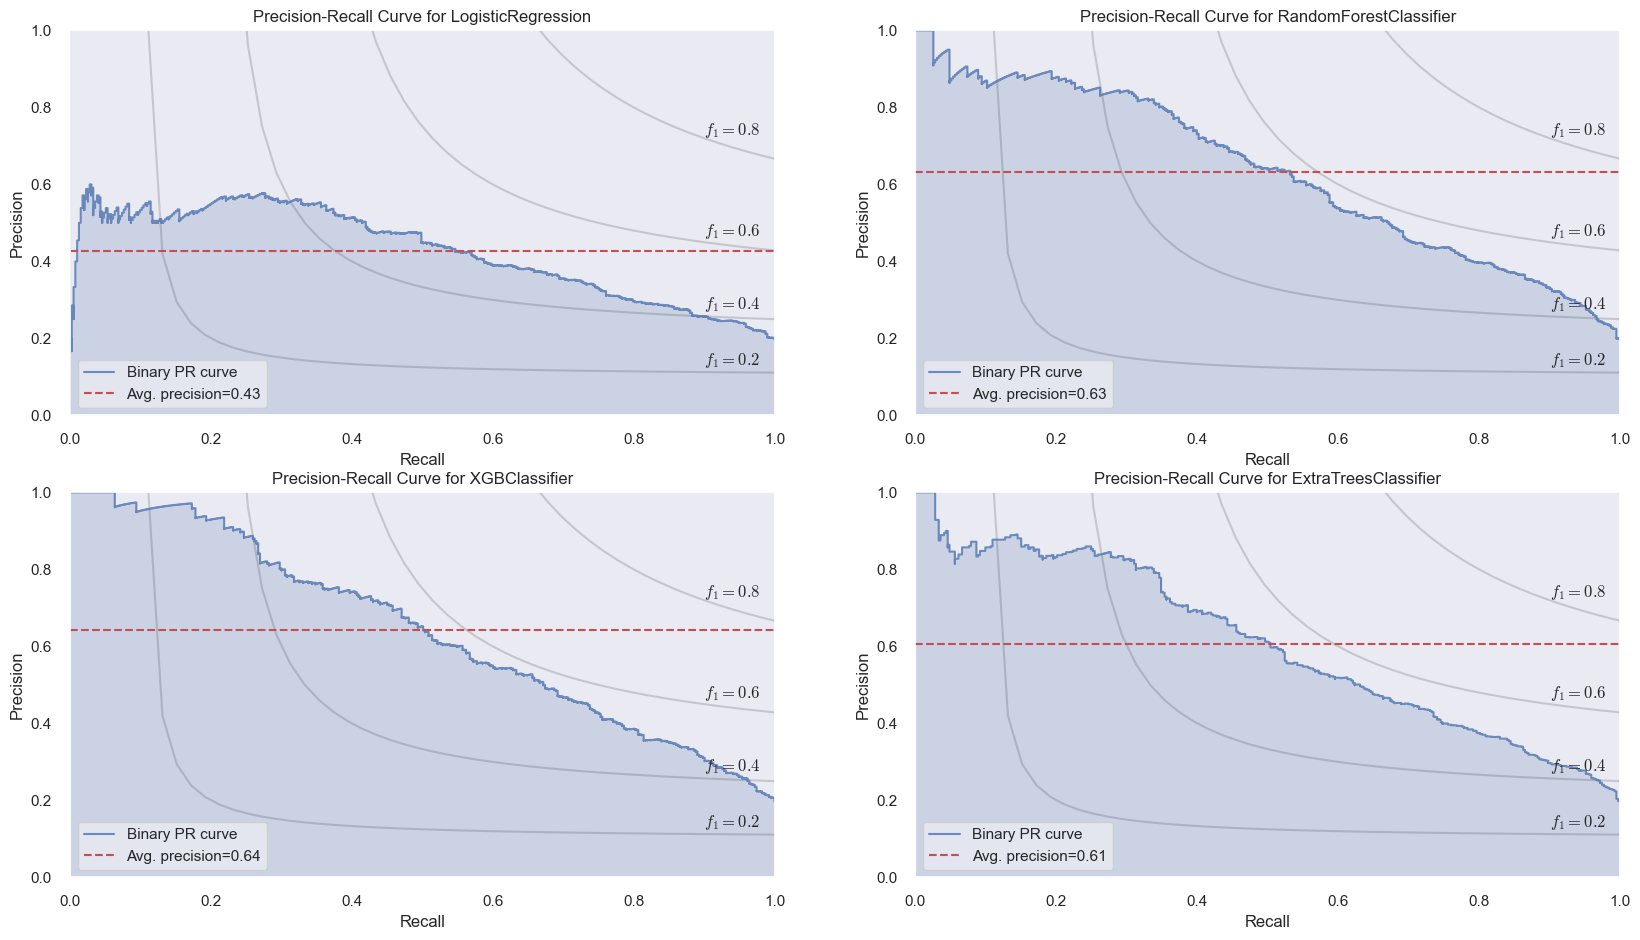

In [75]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 11))

viz = PrecisionRecallCurve(logr, iso_f1_curves=True, ax=ax1)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = PrecisionRecallCurve(rfc, iso_f1_curves=True, ax=ax2)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = PrecisionRecallCurve(xgb_model, iso_f1_curves=True, ax=ax3)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = PrecisionRecallCurve(et_model, iso_f1_curves=True, ax=ax4)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

### 9.1.4 Lift Curve

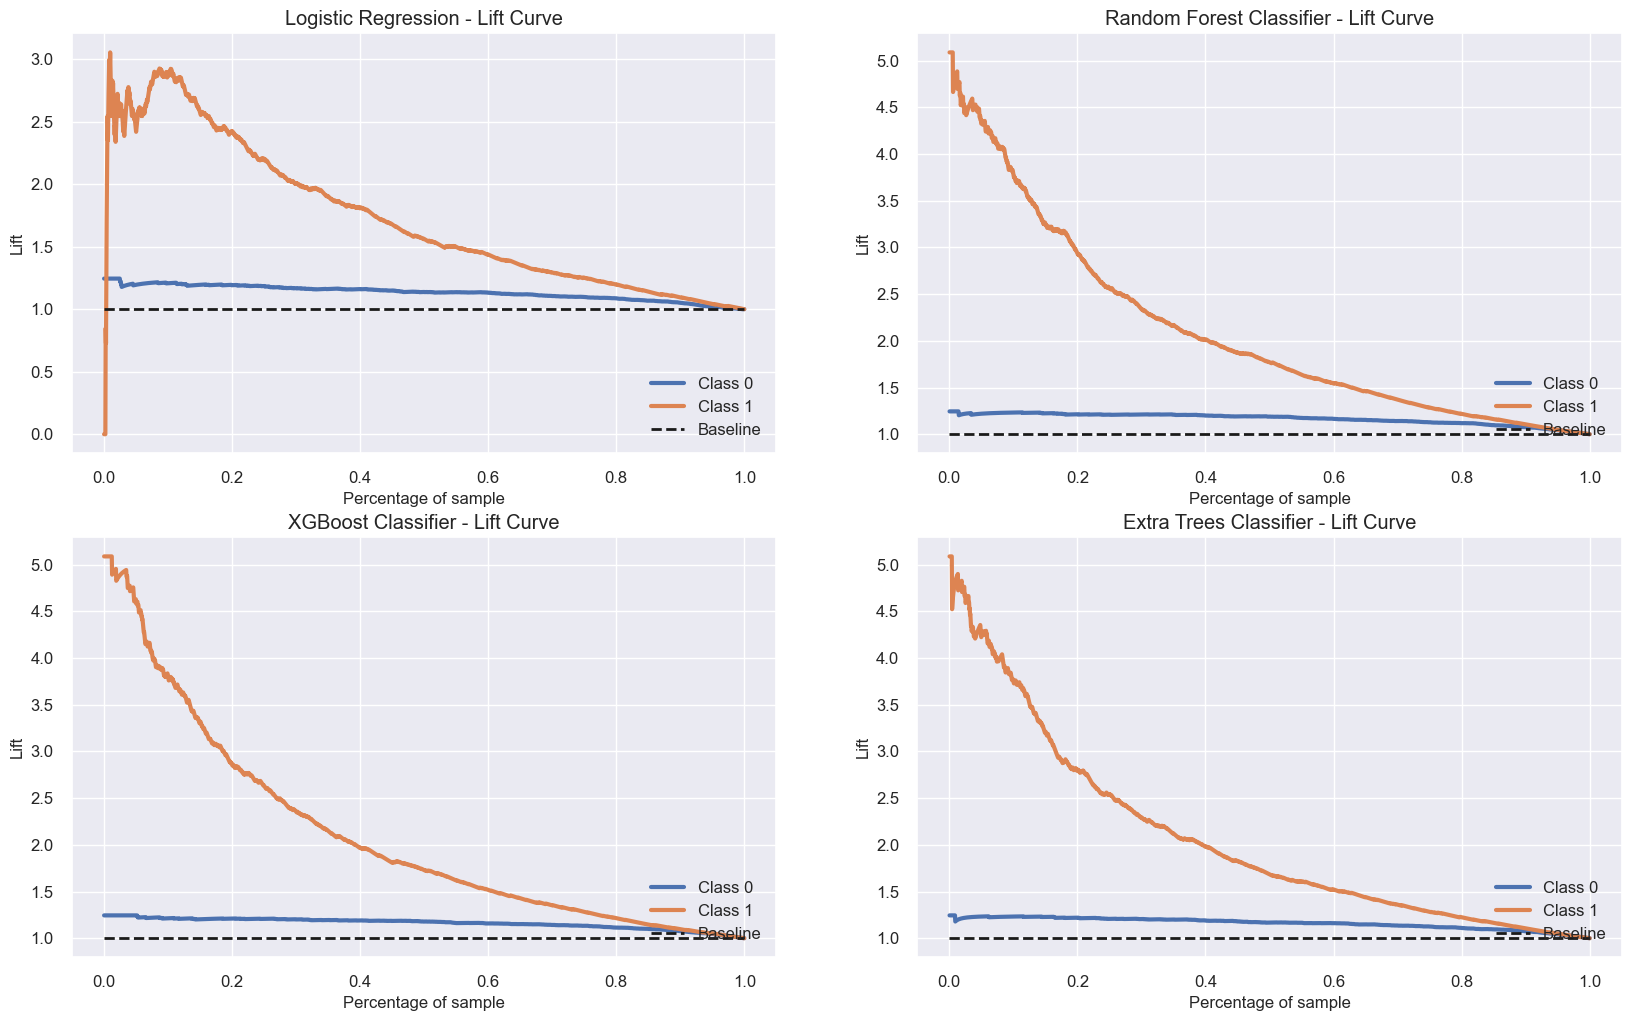

In [76]:
#Plot Lift Curve
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 12))

plot_lift_curve(y_test, y_proba_logr, title='Logistic Regression - Lift Curve', ax=ax1)

plot_lift_curve(y_test, y_proba_rfc, title='Random Forest Classifier - Lift Curve', ax=ax2)

plot_lift_curve(y_test, y_proba_xgb, title='XGBoost Classifier - Lift Curve', ax=ax3) 

plot_lift_curve(y_test, y_proba_etc, title='Extra Trees Classifier - Lift Curve',ax=ax4)  ;

### 9.1.5 Cumulative Gain Curve 

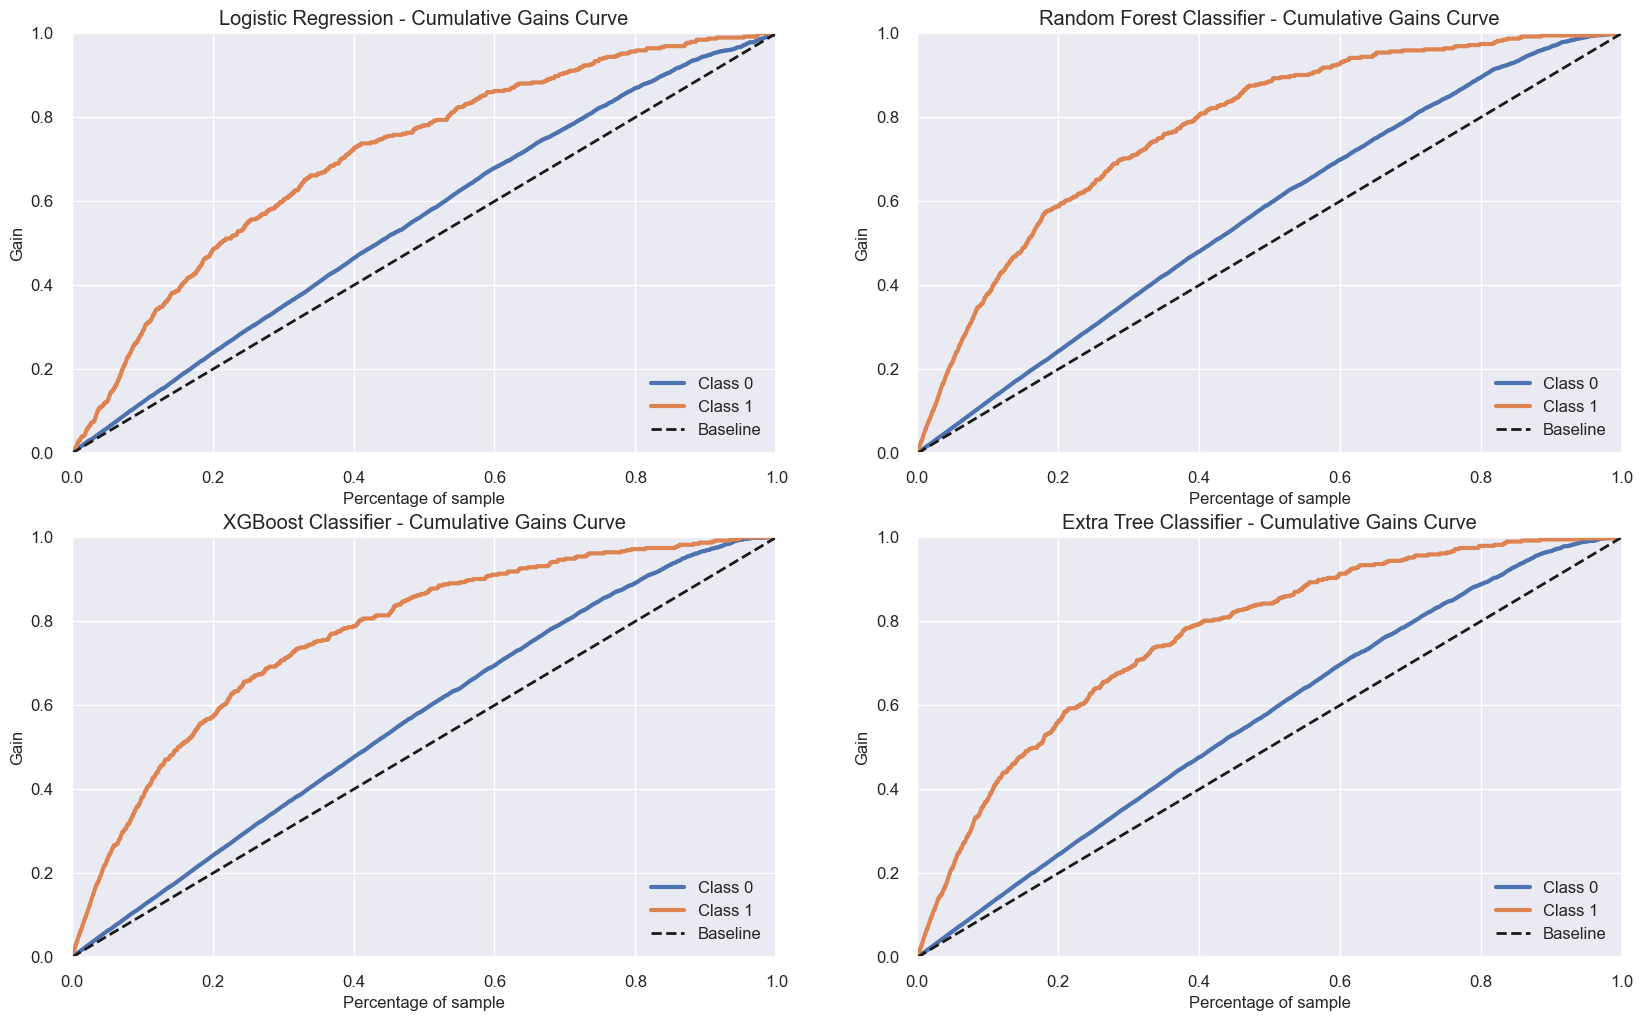

In [77]:
#Plot Cumulative Gain Curve
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 12))

plot_cumulative_gain(y_test, y_proba_logr, title='Logistic Regression - Cumulative Gains Curve', ax=ax1)

plot_cumulative_gain(y_test, y_proba_rfc, title='Random Forest Classifier - Cumulative Gains Curve', ax=ax2)

plot_cumulative_gain(y_test, y_proba_xgb, title='XGBoost Classifier - Cumulative Gains Curve', ax=ax3) 

plot_cumulative_gain(y_test, y_proba_etc, title='Extra Tree Classifier - Cumulative Gains Curve',ax=ax4)  ;

## 9.2 Business Performance

O orçamento para o plano de ação para reduzir o churn rate de clientes será por meio da aplicação de cupons de desconto no valor de RS 250,00. Nesse sentido, a equipe de Data Science, juntamente com as equipes de negócios e marketing, busca um orçamento que possa maximizar o ROI - Return on Investment. A estratégia é criar um dataset com todos com clientes com probabilidade de churn maior que 80% e aplicar o cupom de desconto, de modo a impedir um possível churn e atingir os melhores resultados.
A receita de clientes é calculada da seguinte forma:
 - Clientes com salário abaixo da média: Retorna 3% do salário estimado
 - Clientes com salário acima da média: Retorna 5% do salário estimado 
    
A média salarial estimada é de S 100.090,00. Por exemplo, se o salário anual estimado do cliente for de S 100.000,00, o banco terá um retorno anual de S 100.000,00 x 3% = S 3.000,00 por cliente.

In [78]:
print("Média salarial: {}".format(df_prob['estimated_salary'].mean().round()))

Média salarial: 100090.0


In [79]:
# Criando um Dataframe com apenas os clientes que entraram em churn
df_prob_churn = df_prob

# Criando um Dataframe para analisar as probabilidades de churn e o ROI
df_result = pd.DataFrame()
df_result['customer_id'] = df_prob_churn.customer_id
df_result['salary'] = df_prob_churn.estimated_salary
df_result['prob'] = df_prob_churn.prob
df_result['exited'] = df_prob_churn.exited

df_result['is_greater_than_avg'] = df_result['salary'].apply(lambda x: 1 if x >= 100090.0 else 0)

df_result['ROI'] = df_result['is_greater_than_avg'].apply(lambda x: 1 if x == 1 else 0) 

df_result['ROI'] = df_result['salary'].apply(lambda x: 0.05 * x if x == 1 else 0.03 * x) 
    
df_result.head(10).sort_values('prob', ascending=False)

,customer_id,salary,prob,exited,is_greater_than_avg,ROI
7,15656148,119346.88,0.999719,1,1,3580.4064
2,15619304,113931.57,0.987566,1,1,3417.9471
5,15574012,149756.71,0.480917,1,1,4492.7013
0,15634602,101348.88,0.429466,1,1,3040.4664
9,15592389,71725.73,0.151321,0,0,2151.7719
1,15647311,112542.58,0.145786,0,1,3376.2774
4,15737888,79084.10,0.111811,0,0,2372.5230
8,15792365,74940.50,0.083568,0,0,2248.2150
6,15592531,10062.80,0.073380,0,0,301.8840
3,15701354,93826.63,0.033892,0,0,2814.7989


In [80]:
df_g80 = df_result[df_result['prob'] > 0.8].copy()

In [81]:
df_g80['exited'] = df_g80['exited'].astype('string')

df_g80['is_greater_than_avg'] = df_g80['is_greater_than_avg'].astype('string')

### 9.2.1 Cupom de desconto no valor de R$ 250,00

- Regra: Aplicar o cupom apenas para clientes com probabilidade de churn maior que 80% ( Todos do dataset df_g75 )

Foi aplicado um desconto de 250 nos 3082 clientes com maiores probabilidades de churn ( > 80% ). Dos 100 principais clientes, 46.85% deles eram True Churns e 53.14% eram False Churns. Quando se trata de Salários Estimados, 52.95% deles estavam acima da média e 47.04% deles estavam abaixo da média.

Resultados financeiros: 

- Caso todos os clientes true churn forem recuperados: S 4444628.0
- Prejuízo: S 770500.0
- Lucro: S 3674128.0

Análise dos possíveis cenários: 

- Pessimistic - Lucro: S 2340740.0
- Realistic - Lucro: S 2785202.0
- Optmistic - Lucro: S 3229665.0
- Mean of scenarios - Lucro Final: S 2785202.0

In [82]:
df_g80.dtypes

customer_id              int64
salary                 float64
prob                   float32
exited                  string
is_greater_than_avg     string
ROI                    float64
dtype: object

In [83]:
df_g80.head()

,customer_id,salary,prob,exited,is_greater_than_avg,ROI
2,15619304,113931.57,0.987566,1,1,3417.9471
7,15656148,119346.88,0.999719,1,1,3580.4064
16,15737452,5097.67,0.978310,1,0,152.9301
30,15589475,140469.38,0.984517,1,1,4214.0814
41,15738148,181297.65,0.930082,1,1,5438.9295


In [84]:
# Soma do ROI dos clientes true churn que podem ser recuperados
s = df_g80.loc[df_g80['exited'] == '1', 'ROI'].sum().round()
s

1974767.0

In [85]:
df_g80.shape

(677, 6)

In [86]:
# 100 para cada cliente com probabilidade maior que 75%
prej_base = 770500

print('O lucro é de {}'.format(s - prej_base))

O lucro é de 1204267.0


In [87]:
# Quantidade de clientes com salário maior ou menor que a média
smm = df_g80['is_greater_than_avg'].value_counts(normalize=True) * 100
smm.to_frame()

,is_greater_than_avg
1,53.766617
0,46.233383


In [88]:
# Porcentagem de true e false churns
tfc = df_g80['exited'].value_counts(normalize=True)*100
tfc.to_frame()

,exited
1,92.171344
0,7.828656


In [89]:
# Scenario analysis

# Pessimistic
p_recovered = (s * 0.7).round() - prej_base
print('Pessimistic - Lucro: $', p_recovered)

# Realistic
r_recovered = (s * 0.8).round() - prej_base
print('Realistic - Lucro: $', r_recovered)

# Optmistic
o_recovered = (s * 0.9).round() - prej_base
print('Optmistic - Lucro: $', o_recovered)

# Mean
mean_scenarios = ((p_recovered + r_recovered + o_recovered) / 3).round()
print('Mean of scenarios - Lucro Final: $', mean_scenarios)

Pessimistic - Lucro: $ 611837.0
Realistic - Lucro: $ 809314.0
Optmistic - Lucro: $ 1006790.0
Mean of scenarios - Lucro Final: $ 809314.0


## 9.3 Business Conclusion

Para calcular o Retorno do Investimento ( ROI ), usaremos da divisão entre a média dos cenários ( Lucro final ) e o investimento inicial com os cupons ( RS 770500.0 ).

- ROI: 361%

In [90]:
# ROI 
ROI = round((2785202 / 770500) * 100)

print('ROI: {}%'.format(ROI))

ROI: 361%


# 10.0 Deploy Model to Production

In [91]:
# Save Trained Model
pickle.dump( xgb_model, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/webapp/model/model_churn.pkl', 'wb' ) )

## 10.1 Churn Prediction Class

In [92]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Churn():
    def __init__(self):
        self.home_path = '/Users/luishmq/Documents/repos/churn_prediction/churn_prediction/'
        self.credit_score                = pickle.load(open(self.path + 'webapp/parameter/credit_score.pkl'))
        self.balance                     = pickle.load(open(self.path + 'webapp/parameter/balance.pkl'))
        self.estimated_salary            = pickle.load(open(self.path + 'webapp/parameter/estimated_salary.pkl'))
        self.estimated_monthly_salary    = pickle.load(open(self.path + 'webapp/parameter/estimated_monthly_salary.pkl'))
        self.tenure                      = pickle.load(open(self.path + 'webapp/parameter/tenure.pkl'))
        self.age                         = pickle.load(open(self.path + 'webapp/parameter/age.pkl')) 
        self.gender                         = pickle.load(open(self.path + 'webapp/parameter/gender.pkl'))             

    
    def data_cleaning(self, df1):
        
        # Rename Columns
        old_cols = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

        snake_case = lambda x: inflection.underscore(x)

        new_cols = list( map(snake_case, old_cols))
        df1.columns = new_cols

        return df1

    def feature_engineering(self, df2):

        # Feature Engineering 
        # High Age Feature - Tendem a realizar o churn mais facilmente
        df2['high_age'] = df2['age'].apply(lambda x: 1 if x > 48 else 0)

        # Medium Balance Feature - Tendem a realizar o churn mais facilmente
        df2['medium_balance'] = df2['balance'].apply(lambda x: 1 if 100000.00 < x < 150000.00 else 0)

        # Null Balance Feature - Tendem a não realizar o churn de forma significativa
        df2['null_balance'] = df2['balance'].apply(lambda x: 1 if x == 0 else 0)

        # Number of Products Feature
        df2['low_products'] = df2['num_of_products'].apply(lambda x: 1 if x == 1 or x == 2 else 0)
        df2['high_products'] = df2['num_of_products'].apply(lambda x: 1 if x == 3 or x == 4 else 0)

        # Estimated Monthly Salary Feature
        df2['estimated_monthly_salary'] = df2['estimated_salary'].apply(lambda x: x / 12)
        
        # Filtragem de colunas
        cols_drop = ['row_number', 'customer_id', 'surname']
        df3 = df3.drop(cols_drop, axis=1)
        
        return df2
    
    
    def data_preparation(self, df5):

        # Rescaling
        # credit_score
        df5['credit_score'] = self.credit_score.fit_transform( df5[['credit_score']].values )

        # balance
        df5['balance'] = self.balance.fit_transform(df5[['balance']].values )

        # estimated_salary
        df5['estimated_salary'] = self.estimated_salary.fit_transform( df5[['estimated_salary']].values )

        # estimated_monthly_salary
        df5['estimated_monthly_salary'] = self.estimated_monthly_salary.fit_transform( df5[['estimated_monthly_salary']].values )

        # tenure
        df5['tenure'] = self.tenure.fit_transform( df5[['tenure']].values )

        # age
        df5['age'] = self.age.fit_transform( df5[['age']].values )

        # Encoding
        # gender - Label Encoding
        df5['gender'] = self.gender.fit_transform( df5['gender'] )

        # geography - One Hot Encoding 
        df5 = pd.get_dummies( df5, prefix=['geography'], columns=['geography'] )
        
        return df5
    
    def data_balancing(self, data):
        # Using SMOTE
        smote = SMOTE(random_state=42)
        X_smote, y_smote = smote.fit_resample(df5.loc[:,df5.columns != 'exited'], df5.exited)

        return X_smote,y_smote

    def get_predict(self, model, original_data, test_data):
        
        # model prediction
        pred = model.predict_proba(test_data)
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='records', date_format='iso')
        

In [93]:
df_prob.sort_values('prob',ascending=False).head(10)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,high_age,medium_balance,null_balance,low_products,high_products,estimated_monthly_salary,prob
1962,1963,15692416,Aikenhead,358,Spain,Female,52,8,143542.36,3,1,0,141959.11,1,1,1,0,0,1,11829.925833,0.999977
2614,2615,15640846,Chibueze,546,Germany,Female,58,3,106458.31,4,1,0,128881.87,1,1,1,0,0,1,10740.155833,0.999903
2872,2873,15671591,Castiglione,439,Spain,Male,52,3,96196.24,4,1,0,198874.52,1,1,0,0,0,1,16572.876667,0.999727
2495,2496,15666548,Chung,466,Germany,Female,56,2,111920.13,3,1,0,197634.11,1,1,1,0,0,1,16469.509167,0.999725
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,0,1,0,0,1,9945.573333,0.999719
1265,1266,15662291,Davidson,534,France,Female,55,8,116973.26,3,1,0,122066.50,1,1,1,0,0,1,10172.208333,0.999696
8923,8924,15570002,Burlingame,625,Germany,Female,55,8,118772.71,4,0,0,135853.62,1,1,1,0,0,1,11321.135000,0.999616
7715,7716,15582129,Hsia,517,France,Male,62,1,43772.66,3,1,0,187756.24,1,1,0,0,0,1,15646.353333,0.999489
6255,6256,15589017,Chiu,547,Germany,Male,55,4,111362.76,3,1,0,16922.28,1,1,1,0,0,1,1410.190000,0.999474
70,71,15703793,Konovalova,738,Germany,Male,58,2,133745.44,4,1,0,28373.86,1,1,1,0,0,1,2364.488333,0.999424


In [94]:
df_prob.to_csv("df_prob.csv")